In [ ]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print("Uploaded file:", file_name)

df = pd.read_csv(io.BytesIO(uploaded[file_name]))

print("Dataset Loaded Successfully!")
print("Shape:", df.shape)

df.head(10)

In [ ]:

import pandas as pd
import numpy as np

unnamed_cols = [c for c in df.columns if str(c).lower().startswith('unnamed')]
if unnamed_cols:
    print("Dropping columns:", unnamed_cols)
    df = df.drop(columns=unnamed_cols)

print("Columns before rename:", df.columns.tolist())

rename_map = {}

for c in df.columns:
    lc = c.lower()
    if 'company' in lc and 'name' in lc:
        rename_map[c] = 'company'
    elif 'location' in lc or 'site' in lc:
        rename_map[c] = 'location'
    elif 'datum' in lc or 'date' in lc:
        rename_map[c] = 'date'
    elif 'detail' in lc:
        rename_map[c] = 'detail'
    elif 'status mission' in lc or (('status' in lc) and 'mission' in lc):
        rename_map[c] = 'status_mission'
    elif 'status rocket' in lc or (('status' in lc) and 'rocket' in lc):
        rename_map[c] = 'status_rocket'
    elif 'rocket' in lc and 'status' not in lc and 'name' not in lc:

        rename_map[c] = 'rocket'
    elif 'name' == lc.strip():
        rename_map[c] = 'company'

if rename_map:
    df = df.rename(columns=rename_map)
    print("Renamed columns:", rename_map)

print("Columns after rename:", df.columns.tolist())

if 'date' in df.columns:

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    print("Date parsed. Date null count:", df['date'].isnull().sum())
else:
    print("No 'date' column auto-detected. Check df.columns above.")

if 'location' in df.columns:

    loc_split = df['location'].fillna('').astype(str).map(lambda x: [p.strip() for p in x.rsplit(',', 2)])

    def pad_parts(parts):
        if len(parts) == 3:
            return parts
        elif len(parts) == 2:

            return ['', parts[0], parts[1]]
        elif len(parts) == 1:
            return ['', '', parts[0]]
        else:

            return ['', '', '']
    loc_expanded = loc_split.map(pad_parts).tolist()
    loc_df = pd.DataFrame(loc_expanded, columns=['loc_city','loc_state','loc_country'])

    df = pd.concat([df.reset_index(drop=True), loc_df.reset_index(drop=True)], axis=1)
    print("Location split into loc_city, loc_state, loc_country.")

    display(df[['location','loc_city','loc_state','loc_country']].head(8))
else:
    print("No 'location' column detected. Check df.columns.")


target_col = None
for c in df.columns:
    if 'status_mission' in c.lower() or ('status' in c.lower() and 'mission' in c.lower()) or c.lower() in ['status mission','status_mission','mission_status','mission status','status']:
        target_col = c
        break

if target_col is None:
    for c in df.columns:
        vals = df[c].astype(str).str.lower().unique()[:10]
        if any('success' in str(v) for v in vals) or any('failure' in str(v) for v in vals):
            target_col = c
            break

print("Detected target column:", target_col)
if target_col:
    df['mission_success_raw'] = df[target_col].astype(str).str.strip()

    df['mission_success'] = df['mission_success_raw'].str.lower().apply(lambda x: 1 if 'success' in x else 0)
    print("mission_success value counts:")
    print(df['mission_success'].value_counts(dropna=False))

    print("Sample raw mission statuses:", df['mission_success_raw'].dropna().unique()[:10])
else:
    print("Could not detect a mission status column automatically. Please tell me the correct column name for target.")


print("\n=== DataFrame summary ===")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values (top 15):")
print(df.isnull().sum().sort_values(ascending=False).head(15))


print("\nData types preview:")
display(df.dtypes)

df.to_csv("space_missions_cleaned_step1.csv", index=False)
print("Saved intermediate cleaned file: space_missions_cleaned_step1.csv")

Dropping columns: ['Unnamed: 0.1', 'Unnamed: 0']
Columns before rename: ['Company Name', 'Location', 'Datum', 'Detail', 'Status Rocket', ' Rocket', 'Status Mission']
Renamed columns: {'Company Name': 'company', 'Location': 'location', 'Datum': 'date', 'Detail': 'detail', 'Status Rocket': 'status_rocket', ' Rocket': 'rocket', 'Status Mission': 'status_mission'}
Columns after rename: ['company', 'location', 'date', 'detail', 'status_rocket', 'rocket', 'status_mission']
Date parsed. Date null count: 126
Location split into loc_city, loc_state, loc_country.


,location,loc_city,loc_state,loc_country
0,"LC-39A, Kennedy Space Center, Florida, USA","LC-39A, Kennedy Space Center",Florida,USA
1,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",Site 9401 (SLS-2),Jiuquan Satellite Launch Center,China
2,"Pad A, Boca Chica, Texas, USA","Pad A, Boca Chica",Texas,USA
3,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",Site 200/39,Baikonur Cosmodrome,Kazakhstan
4,"SLC-41, Cape Canaveral AFS, Florida, USA","SLC-41, Cape Canaveral AFS",Florida,USA
5,"LC-9, Taiyuan Satellite Launch Center, China",LC-9,Taiyuan Satellite Launch Center,China
6,"Site 31/6, Baikonur Cosmodrome, Kazakhstan",Site 31/6,Baikonur Cosmodrome,Kazakhstan
7,"LC-101, Wenchang Satellite Launch Center, China",LC-101,Wenchang Satellite Launch Center,China


Detected target column: status_mission
mission_success value counts:
mission_success
1    3879
0     445
Name: count, dtype: int64
Sample raw mission statuses: ['Success' 'Failure' 'Prelaunch Failure' 'Partial Failure']

=== DataFrame summary ===
Shape: (4324, 13)
Columns: ['company', 'location', 'date', 'detail', 'status_rocket', 'rocket', 'status_mission', 'year', 'loc_city', 'loc_state', 'loc_country', 'mission_success_raw', 'mission_success']

Missing values (top 15):
rocket                 3360
year                    126
date                    126
company                   0
location                  0
status_rocket             0
detail                    0
status_mission            0
loc_city                  0
loc_state                 0
loc_country               0
mission_success_raw       0
mission_success           0
dtype: int64

Data types preview:


,0
company,object
location,object
date,"datetime64[ns, UTC]"
detail,object
status_rocket,object
rocket,object
status_mission,object
year,float64
loc_city,object
loc_state,object


Saved intermediate cleaned file: space_missions_cleaned_step1.csv


/tmp/ipython-input-2309169447.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=vals.index, y=vals.values, palette=palette, ax=ax)


Saved: mission_success_distribution_fixed_v2.png


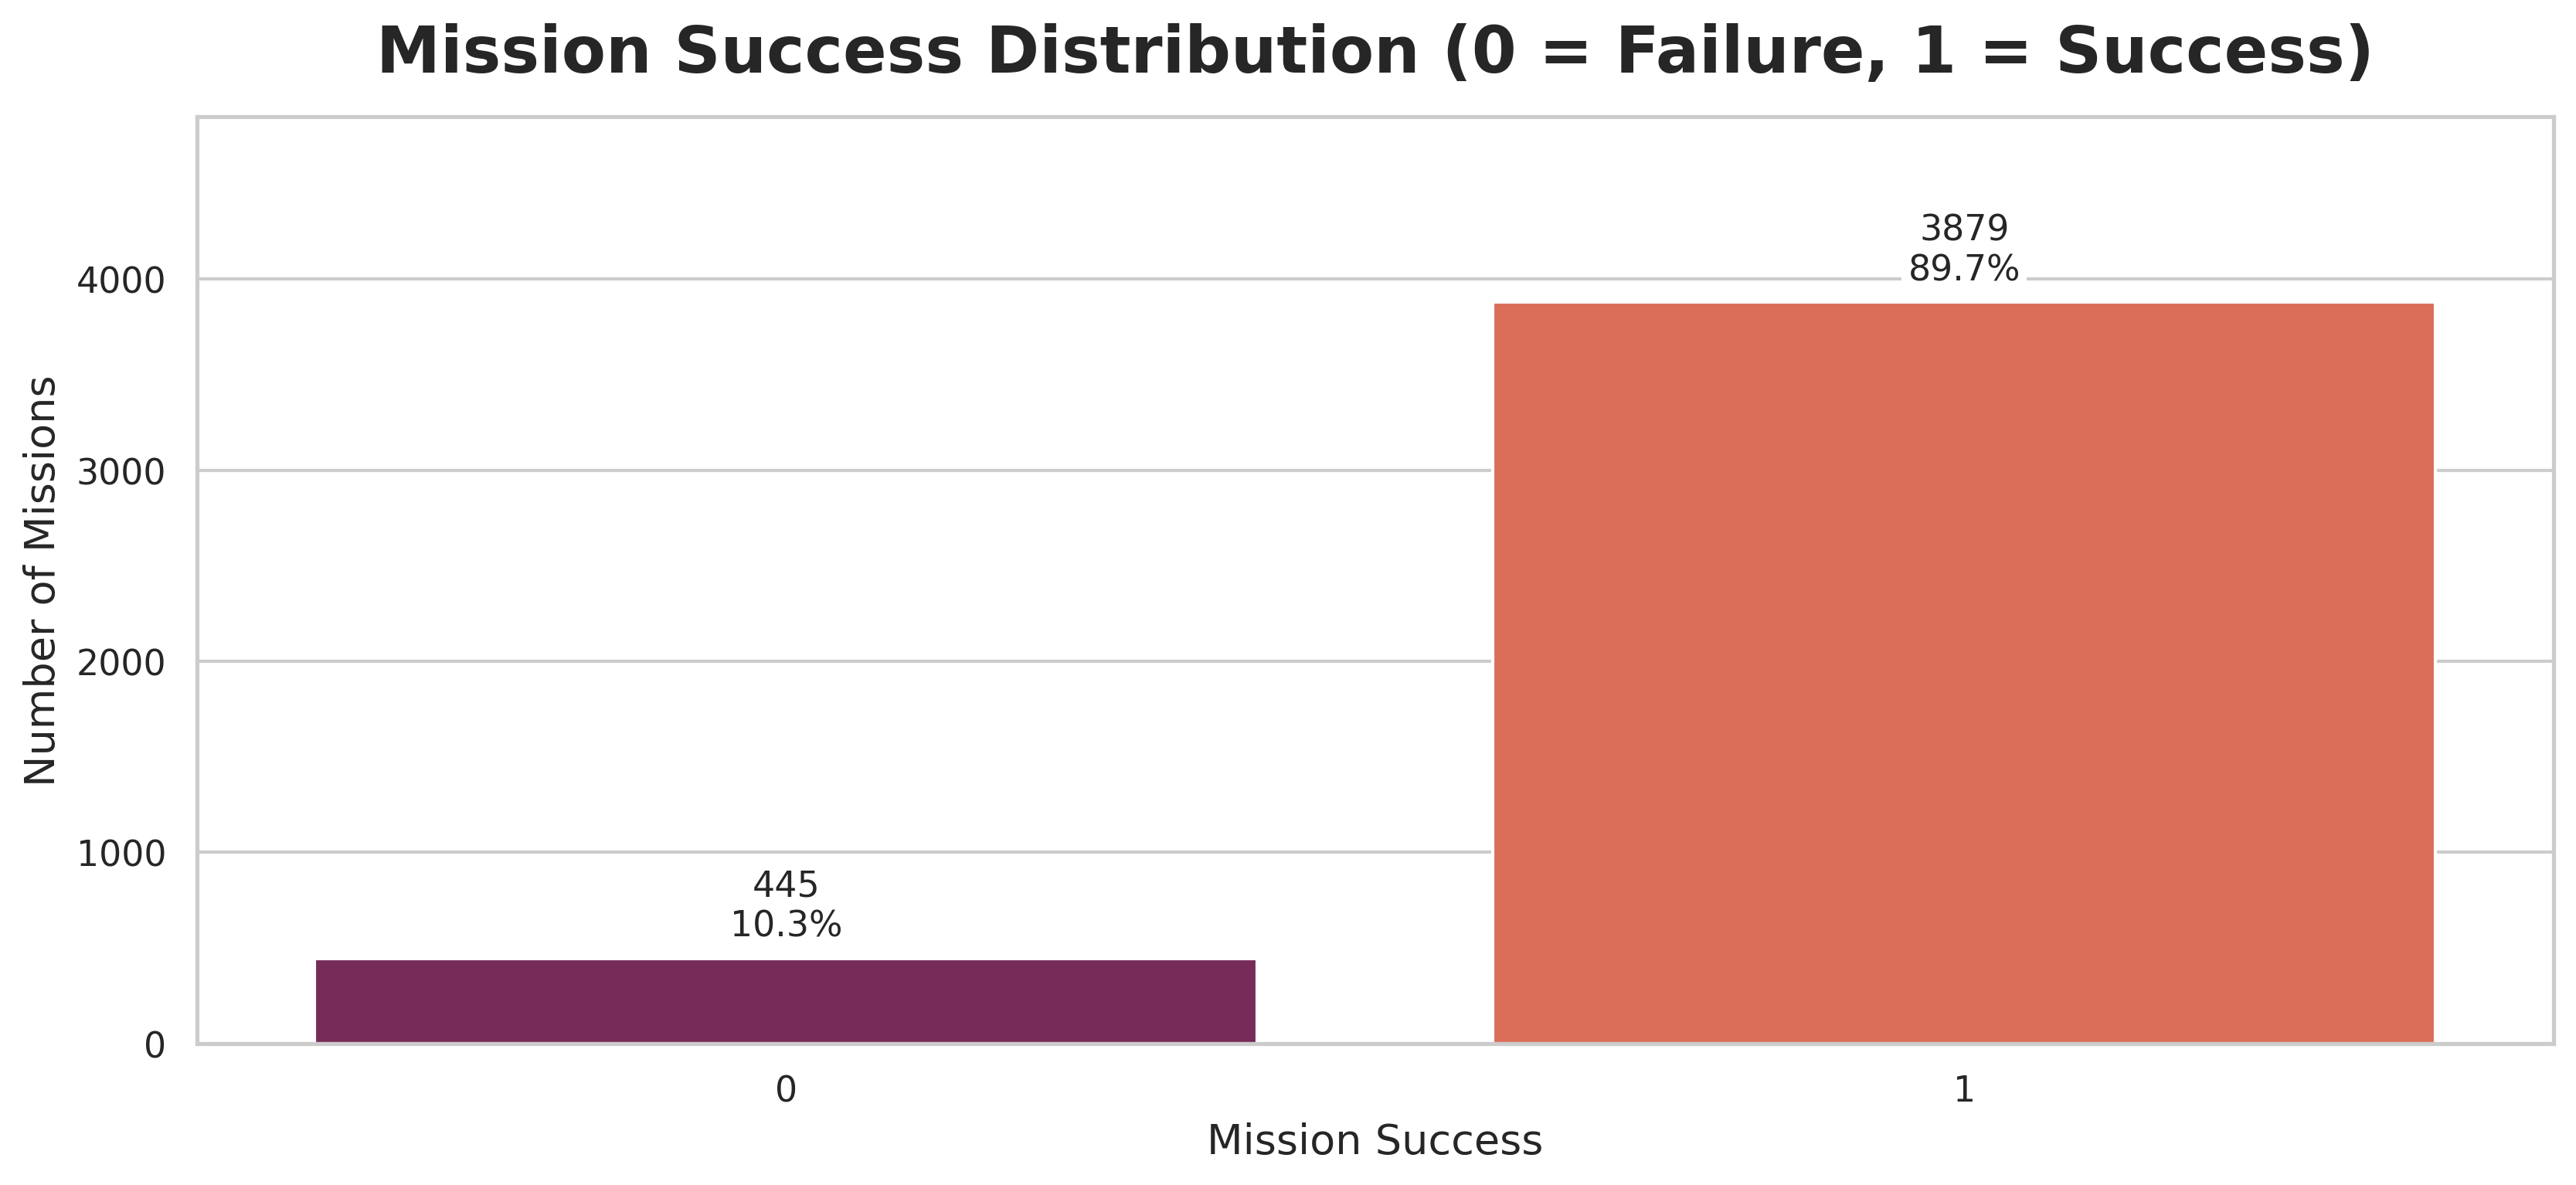

/tmp/ipython-input-2309169447.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_companies.values, y=top10_companies.index, palette=pal, ax=ax)


Saved: top10_companies_counts_fixed_v2.png


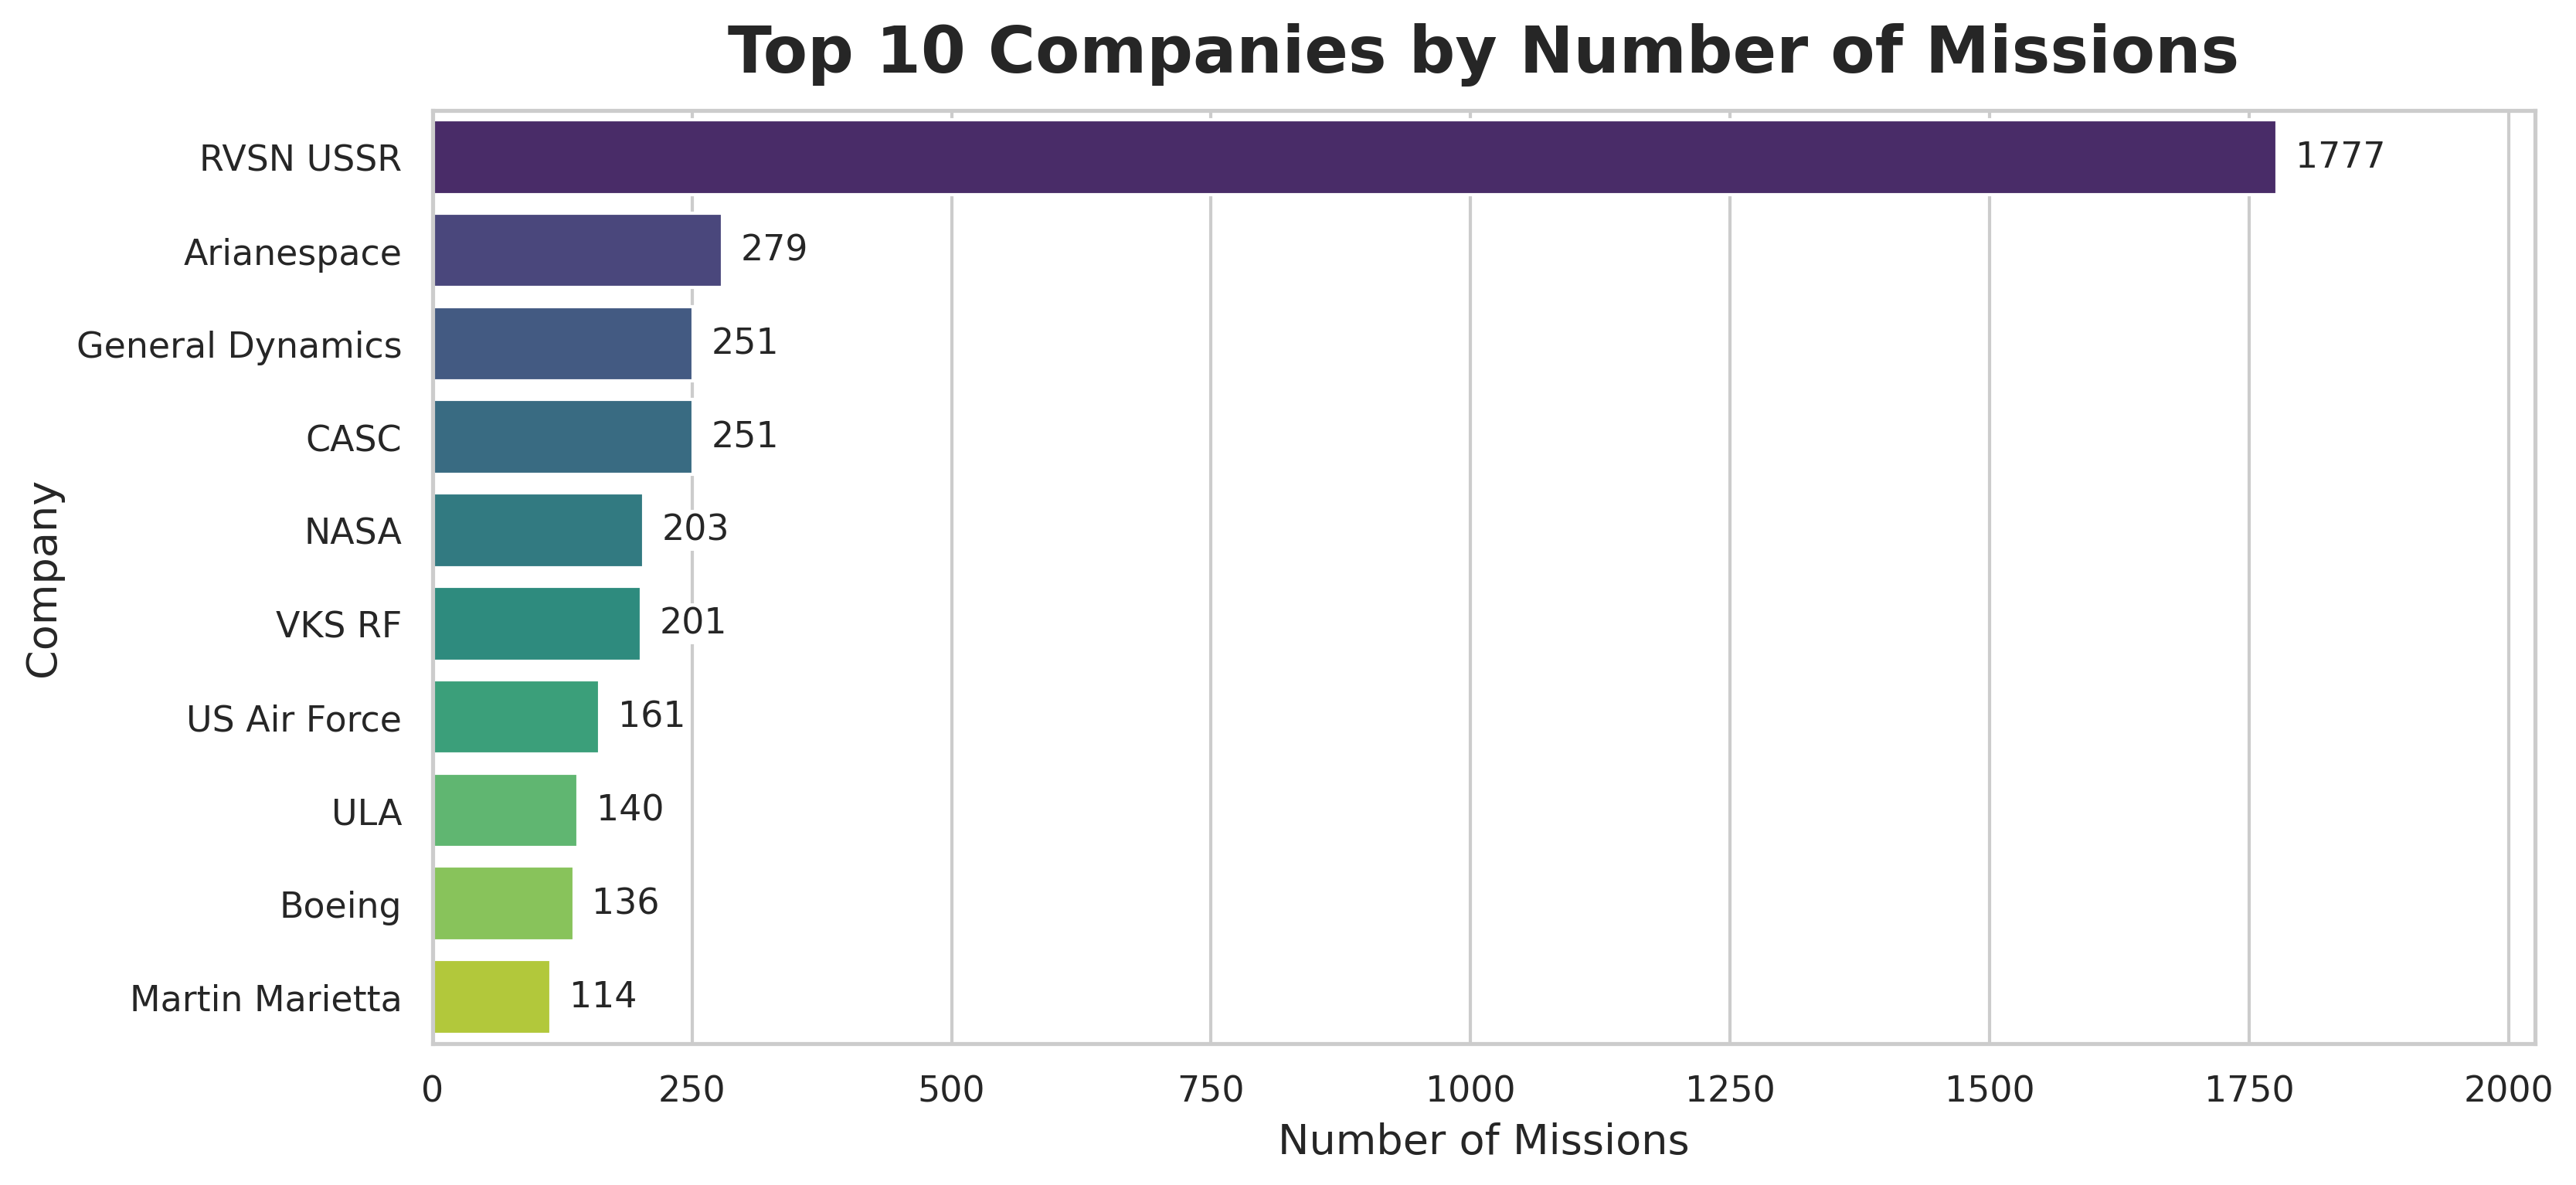

/tmp/ipython-input-2309169447.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean', y=company_success.index, data=company_success.reset_index(), palette=pal, ax=ax)


Saved: top10_companies_successrate_fixed_v2.png


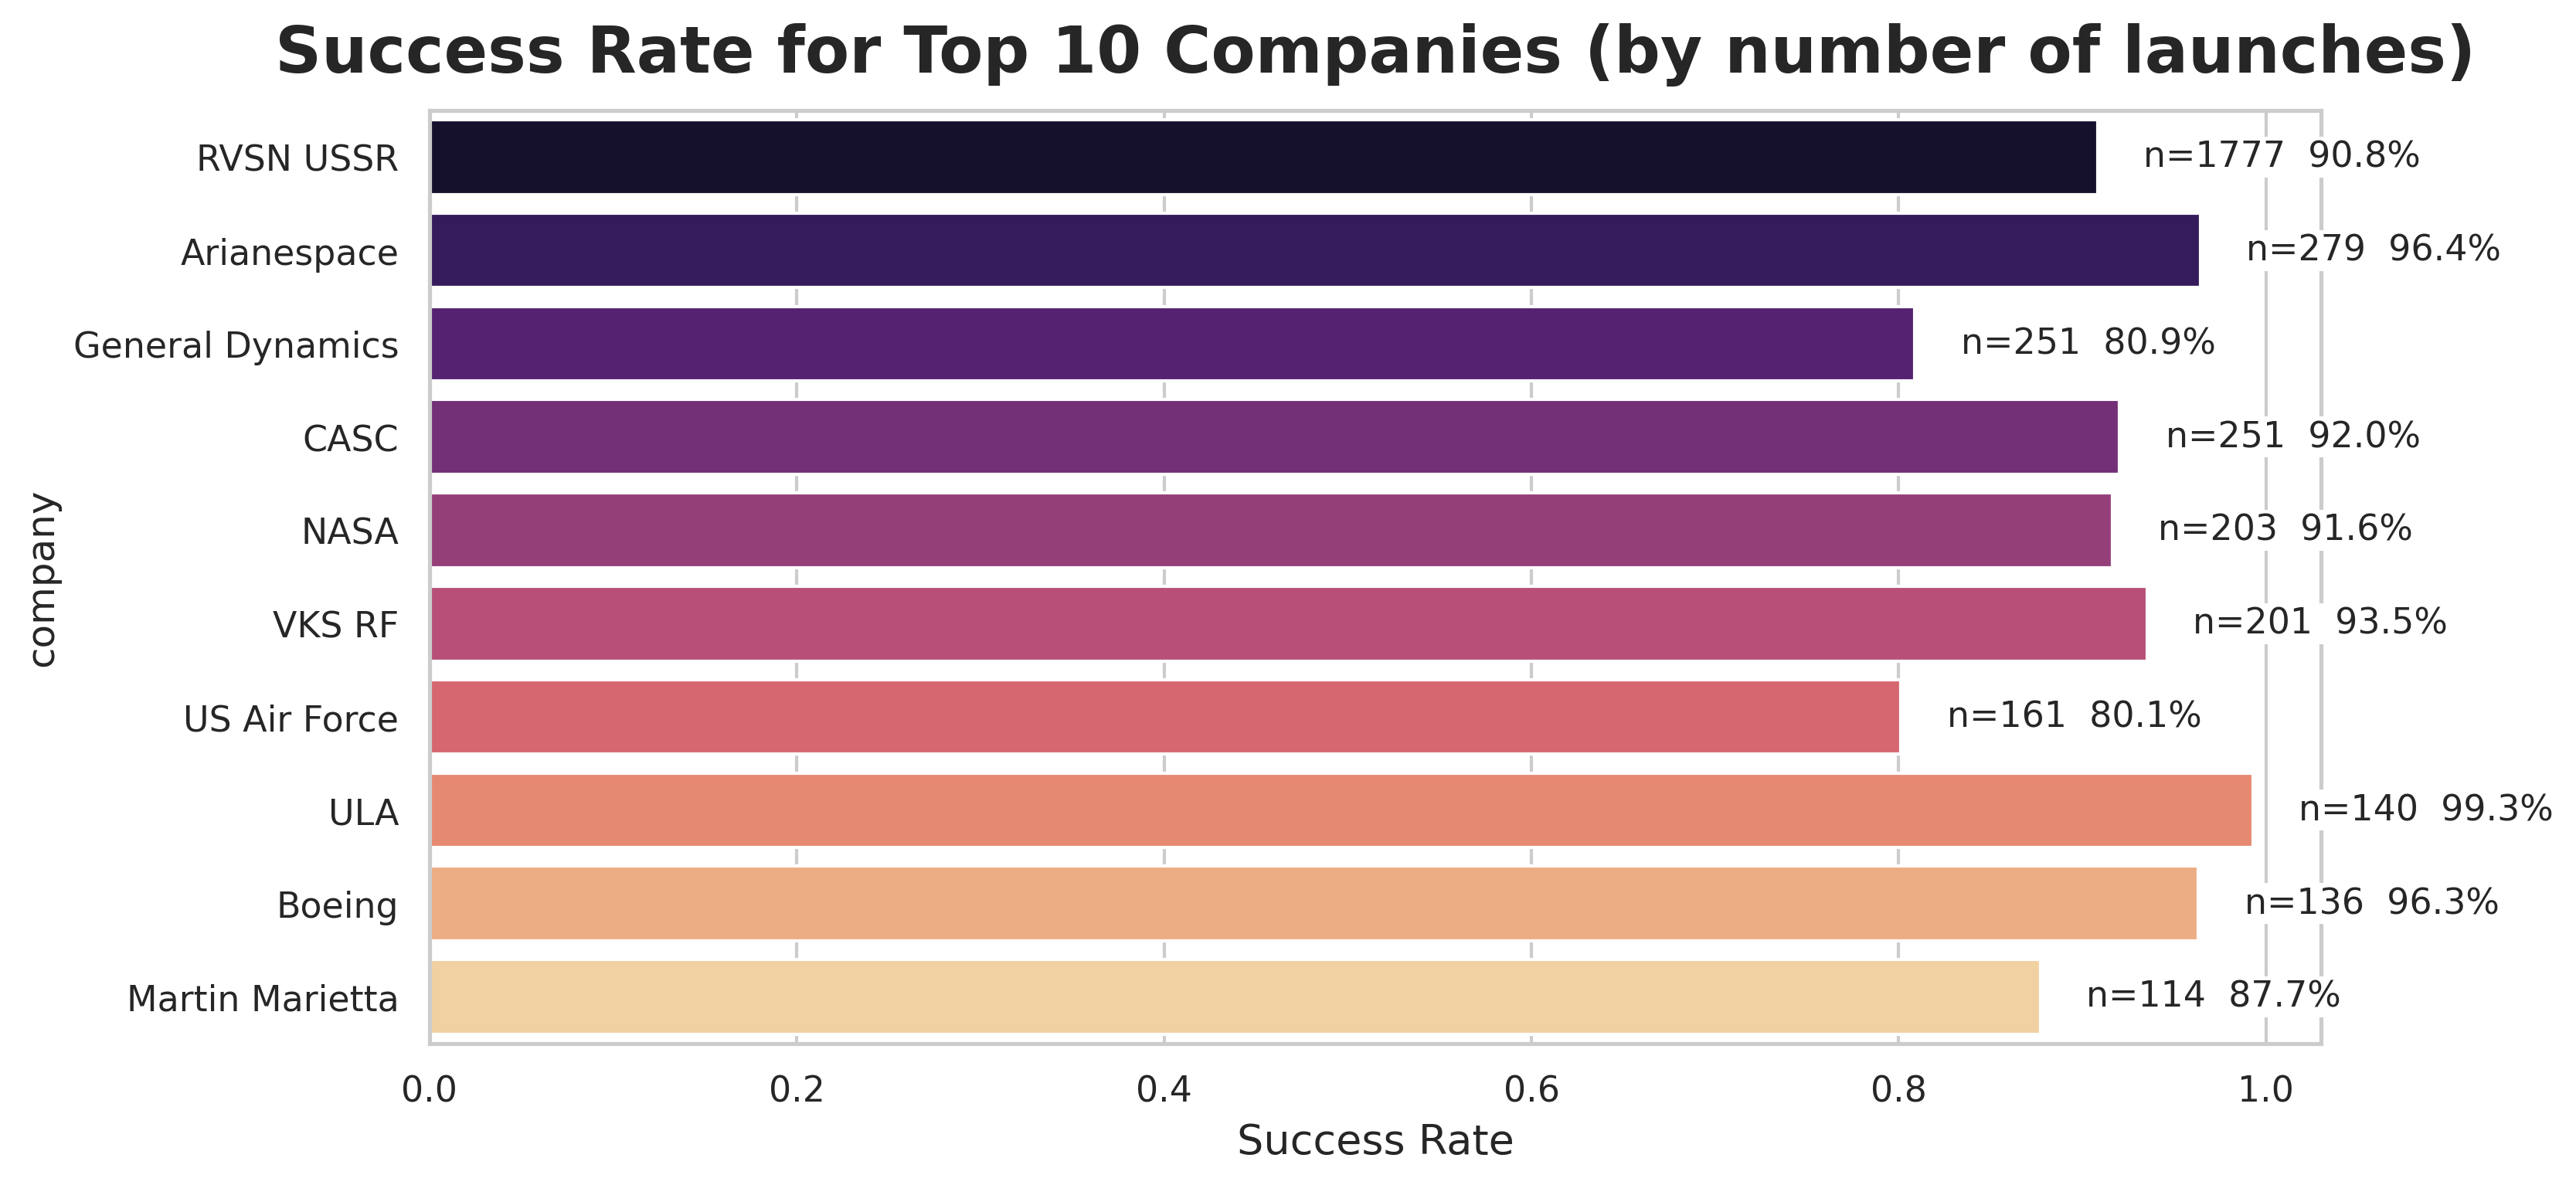

/tmp/ipython-input-2309169447.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_countries.values, y=top10_countries.index, palette=pal, ax=ax)


Saved: top10_countries_counts_fixed_v2.png


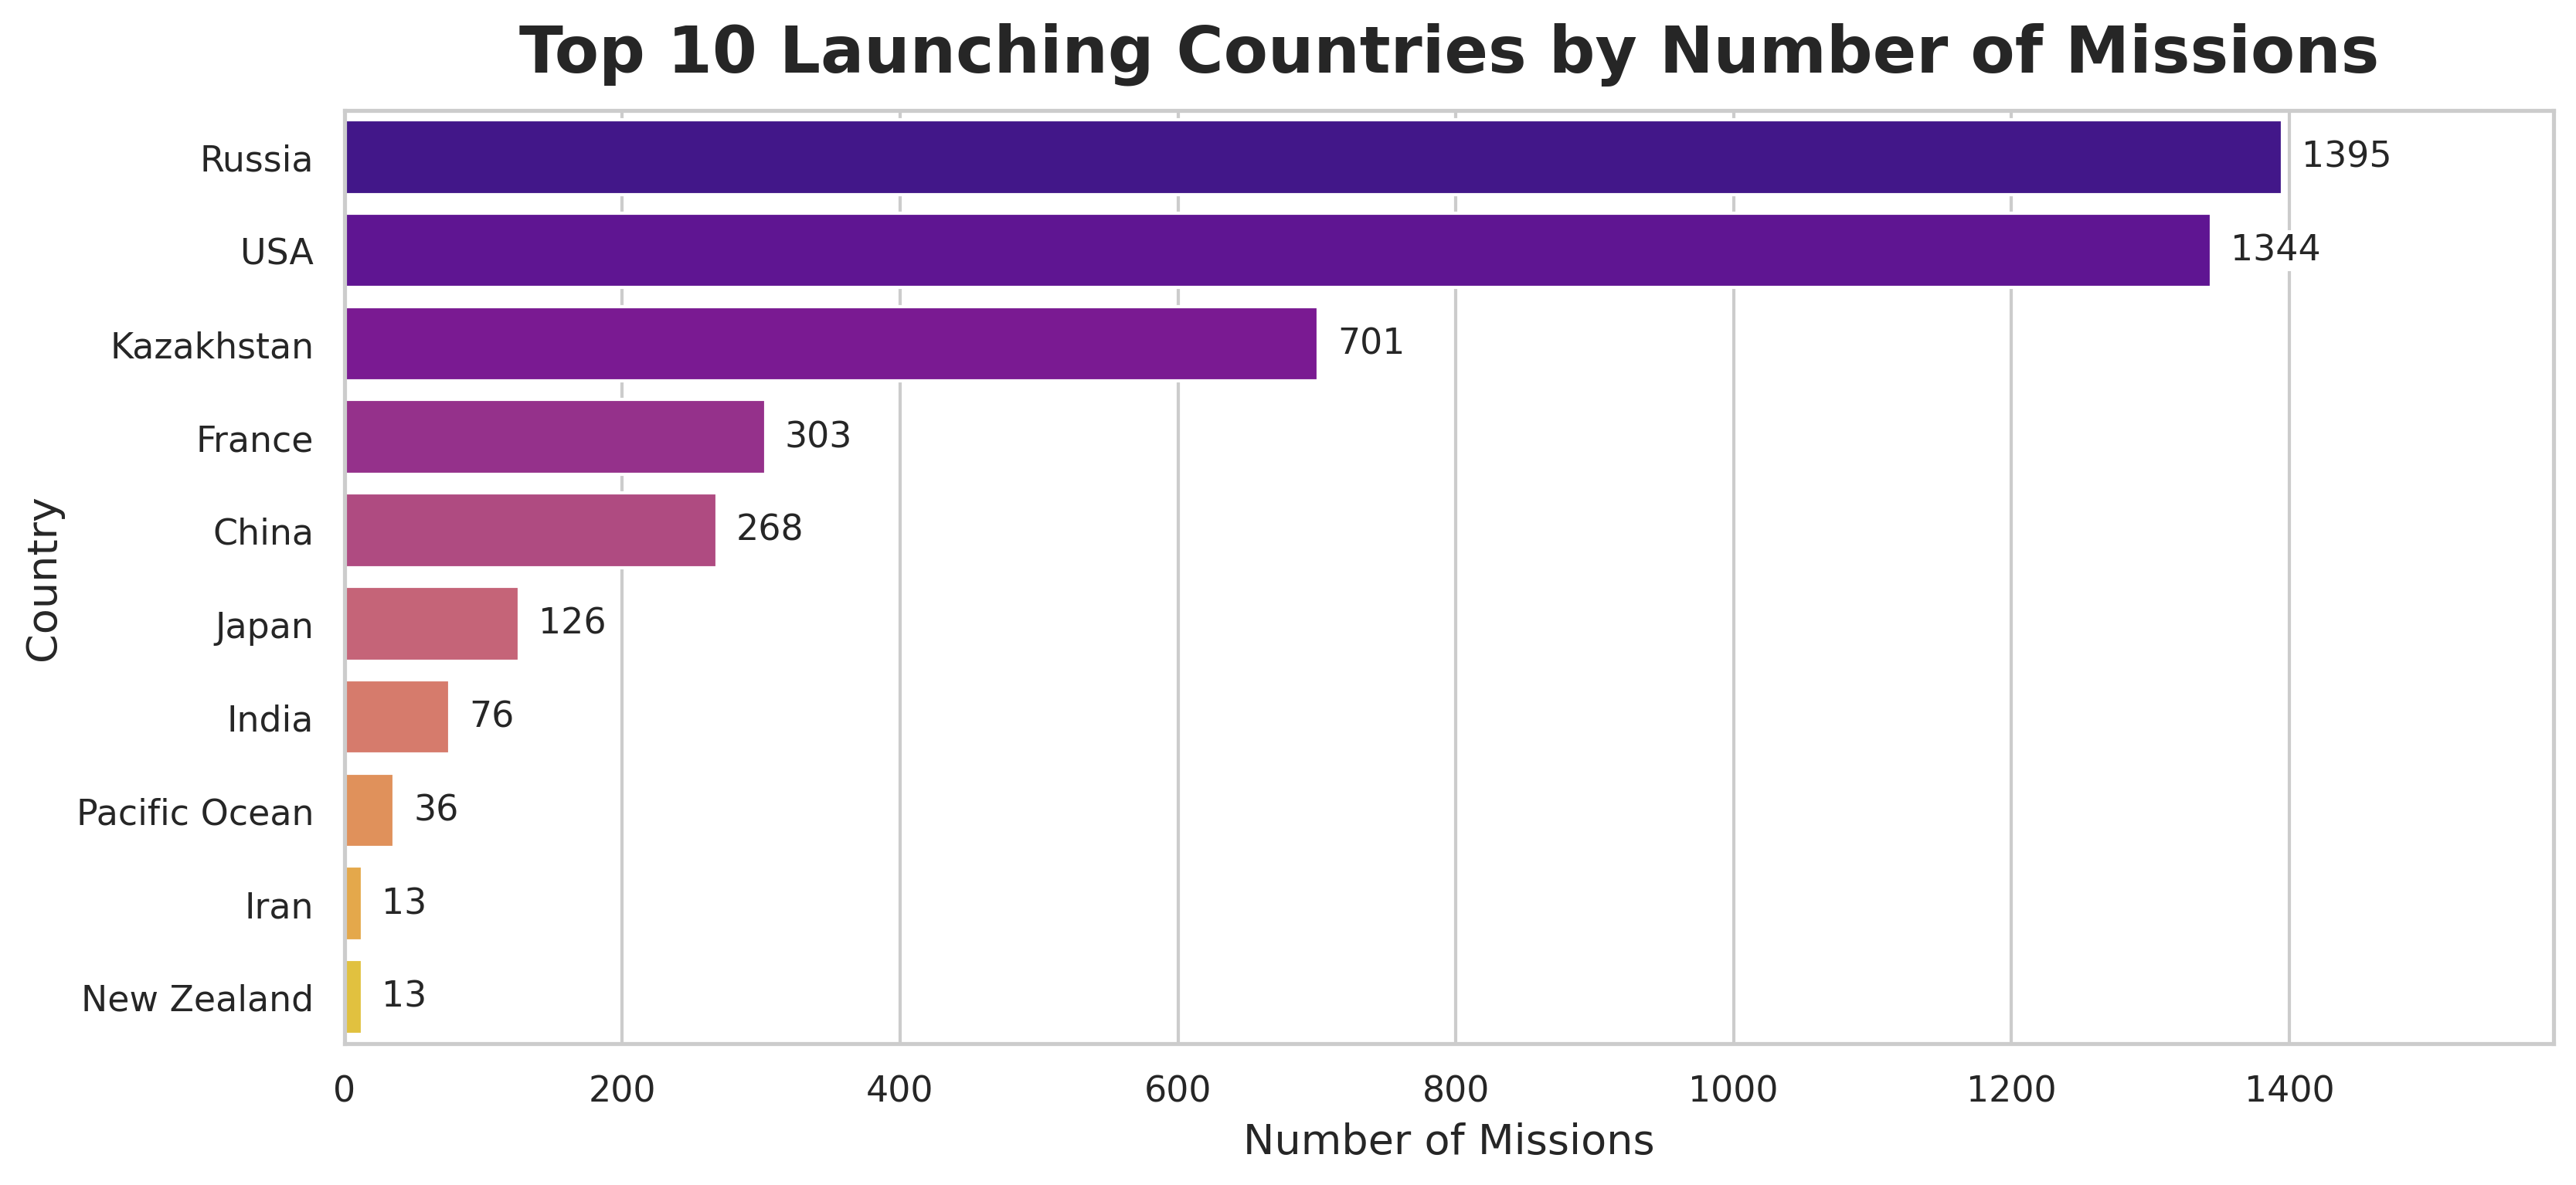

Saved: missions_per_year_fixed_v2.png


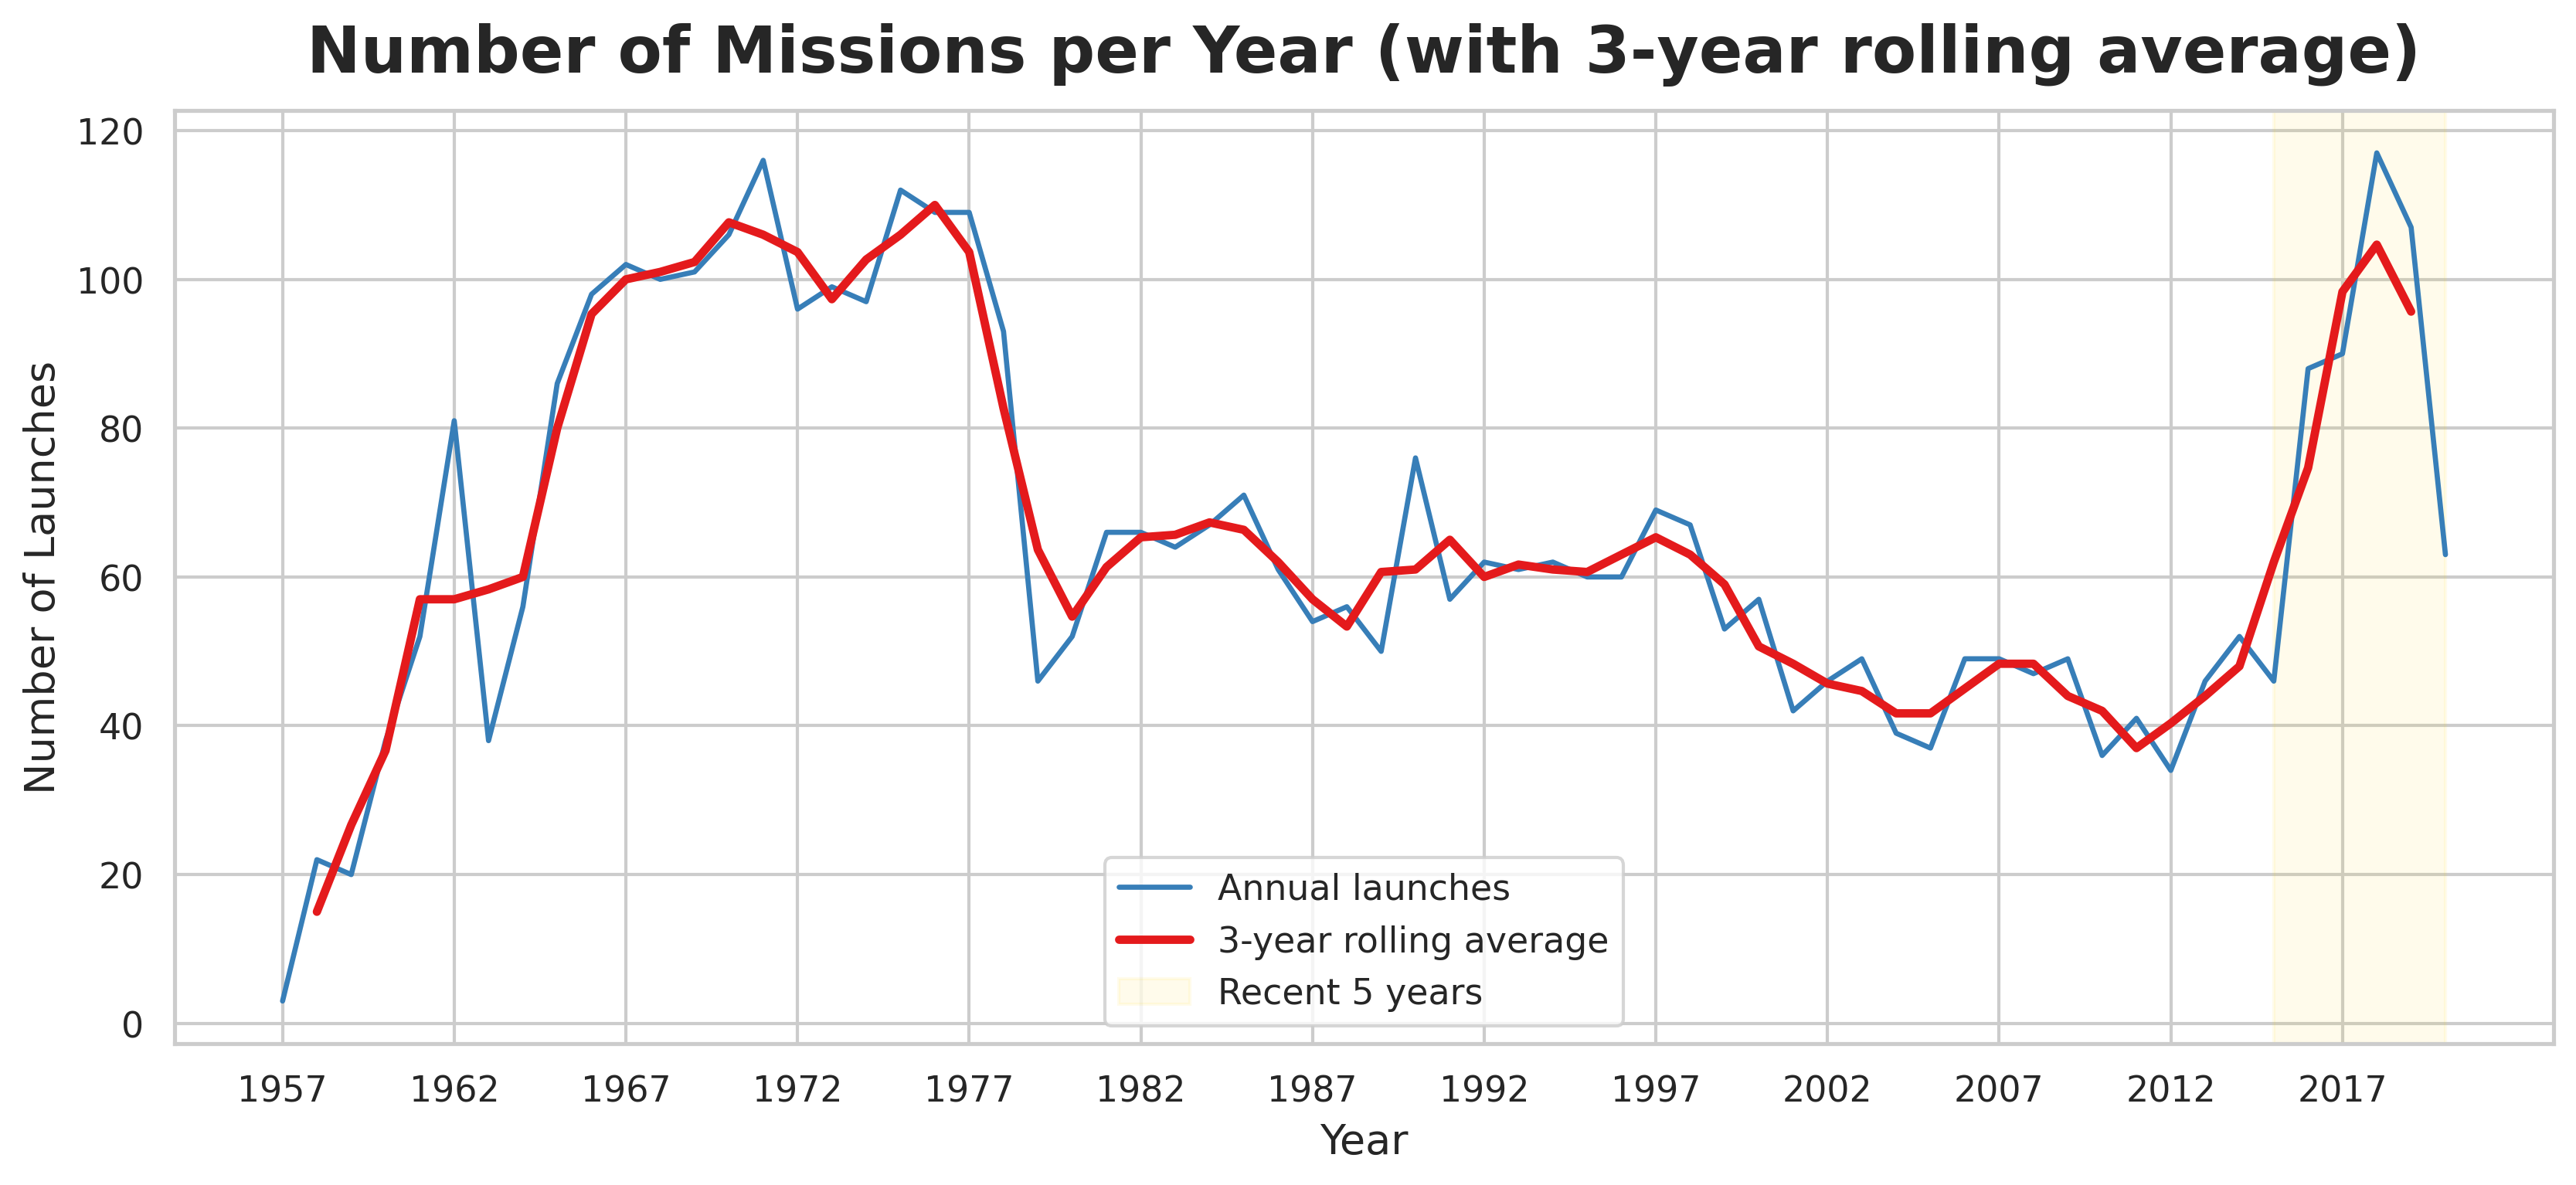

Saved: success_rate_per_year_fixed_v2.png


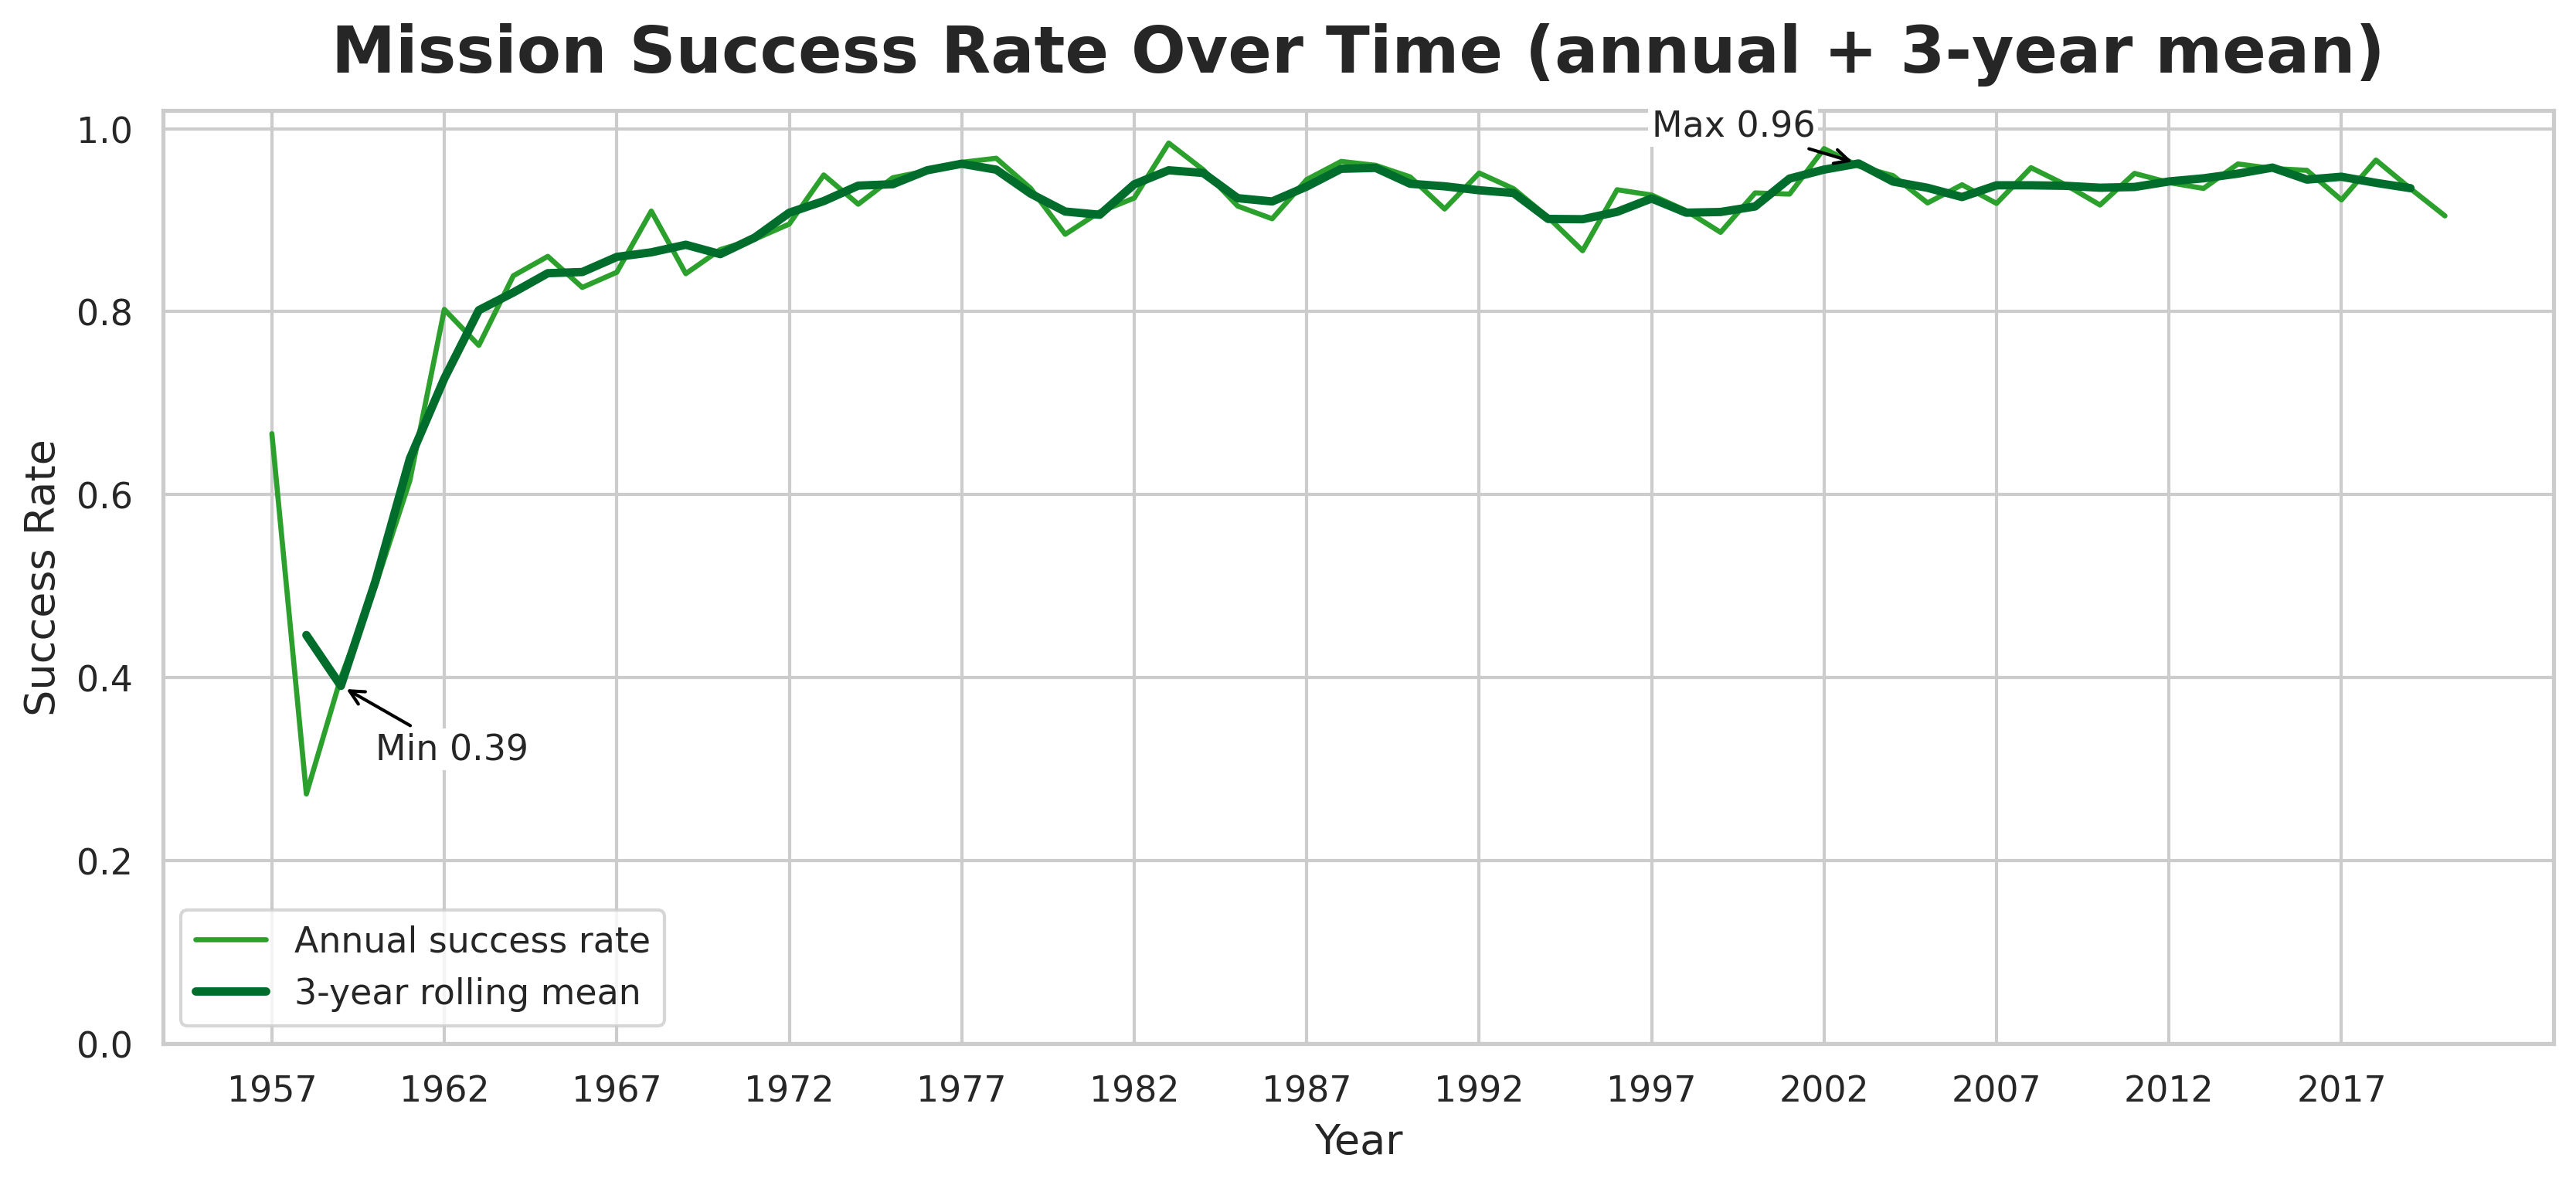

All fixed HD EDA plots created and saved.


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


DPI = 300
FIGSIZE = (11,5)
sns.set_theme(style="whitegrid")

TITLE_FS = 20
LABEL_FS = 13
ANNOT_FS = 11

def save_show(fig, fname):
    fig.set_constrained_layout(True)
    out = f"{fname}.png"
    fig.savefig(out, bbox_inches='tight', dpi=DPI)
    print("Saved:", out)
    plt.show()

top10_companies = df['company'].value_counts().head(10)
top10_idx = top10_companies.index.tolist()
company_success = df[df['company'].isin(top10_idx)].groupby('company')['mission_success'].agg(['mean','count']).reindex(top10_idx)
top10_countries = df['loc_country'].value_counts().head(10)
year_counts = df.groupby('year').size().sort_index()
year_success = df.groupby('year')['mission_success'].mean().sort_index()
total = df.shape[0]

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

vals = df['mission_success'].value_counts().sort_index()
palette = sns.color_palette("rocket", n_colors=2)
bars = sns.barplot(x=vals.index, y=vals.values, palette=palette, ax=ax)

ax.set_title("Mission Success Distribution (0 = Failure, 1 = Success)", fontsize=TITLE_FS, pad=14)
ax.set_xlabel("Mission Success", fontsize=LABEL_FS)
ax.set_ylabel("Number of Missions", fontsize=LABEL_FS)

ymax = vals.values.max()
ax.set_ylim(0, ymax * 1.25)

for i, v in enumerate(vals.values):
    pct = v / total * 100
    ax.text(i, v + ymax*0.03, f"{v}\n{pct:.1f}%", ha='center', fontsize=ANNOT_FS,
            bbox=dict(facecolor='white', edgecolor='none', pad=2.0), clip_on=False)

ax.set_xticks([0,1])
ax.set_xlim(-0.5, 1.5)
save_show(fig, "mission_success_distribution_fixed_v2")

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
pal = sns.color_palette("viridis", n_colors=top10_companies.size)
sns.barplot(x=top10_companies.values, y=top10_companies.index, palette=pal, ax=ax)
ax.set_title("Top 10 Companies by Number of Missions", fontsize=TITLE_FS, pad=12)
ax.set_xlabel("Number of Missions", fontsize=LABEL_FS)
ax.set_ylabel("Company", fontsize=LABEL_FS)

for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(width + top10_companies.values.max()*0.01, y, f"{int(width)}", va='center',
            fontsize=ANNOT_FS, bbox=dict(facecolor='white', edgecolor='none', pad=1.0), clip_on=False)
ax.set_xlim(0, top10_companies.values.max()*1.14)
save_show(fig, "top10_companies_counts_fixed_v2")


fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
pal = sns.color_palette("magma", n_colors=len(company_success))
sns.barplot(x='mean', y=company_success.index, data=company_success.reset_index(), palette=pal, ax=ax)
ax.set_title("Success Rate for Top 10 Companies (by number of launches)", fontsize=TITLE_FS, pad=12)
ax.set_xlabel("Success Rate", fontsize=LABEL_FS)
ax.set_xlim(0,1.03)


for i,(mean_val,cnt) in enumerate(zip(company_success['mean'], company_success['count'])):
    ax.text(mean_val + 0.025, i, f"n={int(cnt)}  {mean_val*100:.1f}%", va='center',
            fontsize=ANNOT_FS, bbox=dict(facecolor='white', edgecolor='none', pad=1.0), clip_on=False)
save_show(fig, "top10_companies_successrate_fixed_v2")



fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
pal = sns.color_palette("plasma", n_colors=top10_countries.size)
sns.barplot(x=top10_countries.values, y=top10_countries.index, palette=pal, ax=ax)
ax.set_title("Top 10 Launching Countries by Number of Missions", fontsize=TITLE_FS, pad=12)
ax.set_xlabel("Number of Missions", fontsize=LABEL_FS)
ax.set_ylabel("Country", fontsize=LABEL_FS)
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(width + top10_countries.values.max()*0.01, y, f"{int(width)}", va='center',
            fontsize=ANNOT_FS, bbox=dict(facecolor='white', edgecolor='none', pad=1.0), clip_on=False)
ax.set_xlim(0, top10_countries.values.max()*1.14)
save_show(fig, "top10_countries_counts_fixed_v2")


fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.plot(year_counts.index, year_counts.values, label='Annual launches', linewidth=1.6, color='#377eb8')
rolling = year_counts.rolling(window=3, center=True).mean()
ax.plot(rolling.index, rolling.values, label='3-year rolling average', color='#e41a1c', linewidth=2.6)

if not year_counts.empty:
    max_y = int(year_counts.index.max())
    ax.axvspan(max_y-5, max_y, color='gold', alpha=0.08, label='Recent 5 years')
ax.set_title("Number of Missions per Year (with 3-year rolling average)", fontsize=TITLE_FS, pad=12)
ax.set_xlabel("Year", fontsize=LABEL_FS)
ax.set_ylabel("Number of Launches", fontsize=LABEL_FS)
ax.legend()
ax.set_xticks(range(int(year_counts.index.min()), int(year_counts.index.max())+1, 5))
plt.xticks(rotation=0)
save_show(fig, "missions_per_year_fixed_v2")


fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.plot(year_success.index, year_success.values, label='Annual success rate', linewidth=1.6, color='#2ca02c')
rolling_succ = year_success.rolling(window=3, center=True).mean()
ax.plot(rolling_succ.index, rolling_succ.values, label='3-year rolling mean', color='#006d2c', linewidth=2.6)
ax.set_ylim(0,1.02)
ax.set_title("Mission Success Rate Over Time (annual + 3-year mean)", fontsize=TITLE_FS, pad=12)
ax.set_xlabel("Year", fontsize=LABEL_FS)
ax.set_ylabel("Success Rate", fontsize=LABEL_FS)
if not rolling_succ.dropna().empty:
    rc = rolling_succ.dropna()
    min_year = int(rc.idxmin())
    max_year = int(rc.idxmax())
    min_val = float(rc.min())
    max_val = float(rc.max())
    ax.annotate(f"Min {min_val:.2f}", xy=(min_year, min_val), xytext=(min_year+1, max(min_val-0.08, 0.02)),
                arrowprops=dict(arrowstyle="->", color='black'), fontsize=11,
                bbox=dict(facecolor='white', edgecolor='none', pad=1.0), clip_on=False)
    ax.annotate(f"Max {max_val:.2f}", xy=(max_year, max_val), xytext=(max_year-6, min(max_val+0.03, 1.01)),
                arrowprops=dict(arrowstyle="->", color='black'), fontsize=11,
                bbox=dict(facecolor='white', edgecolor='none', pad=1.0), clip_on=False)
ax.legend()
ax.set_xticks(range(int(year_success.index.min()), int(year_success.index.max())+1, 5))
plt.xticks(rotation=0)
save_show(fig, "success_rate_per_year_fixed_v2")

print("All fixed HD EDA plots created and saved.")

In [ ]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


features = [
    'company',
    'loc_city',
    'loc_state',
    'loc_country',
    'rocket',
    'year',
    'status_rocket'
]
target = 'mission_success'


model_df = df[features + [target]].copy()
print("Initial modeling DF shape:", model_df.shape)


if 'rocket' in model_df.columns:

    model_df['rocket'] = model_df['rocket'].astype(str).str.strip()

    model_df['rocket'] = model_df['rocket'].replace({'': np.nan, 'nan': np.nan, 'None': np.nan})

    model_df['rocket'] = model_df['rocket'].str.replace(r'[^0-9\.\-]', '', regex=True)

    model_df['rocket'] = pd.to_numeric(model_df['rocket'], errors='coerce')


    print("\nSample of cleaned 'rocket' values (first 10):")
    print(model_df['rocket'].head(10).tolist())


if 'rocket' in model_df.columns:
    median_val = model_df['rocket'].median()
    print("\nrocket median (used to fill NaNs):", median_val)
    model_df['rocket'] = model_df['rocket'].fillna(median_val)


cat_cols = ['company', 'loc_city', 'loc_state', 'loc_country', 'status_rocket']
for col in cat_cols:
    if col in model_df.columns:
        model_df[col] = model_df[col].fillna("Unknown")


print("\nMissing values after cleaning:")
print(model_df.isnull().sum())


encoders = {}
for col in cat_cols:
    if col in model_df.columns:
        le = LabelEncoder()
        model_df[col] = le.fit_transform(model_df[col].astype(str))
        encoders[col] = le
        print(f"Encoded: {col} (unique -> {len(le.classes_)})")


X = model_df[features]
y = model_df[target]

print("\nFeature matrix X shape:", X.shape)
print("Target y shape:", y.shape)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("\nTrain/Test split shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


print("\nmodel_df.head():")
display(model_df.head(6))


model_df.to_csv("space_model_df_cleaned.csv", index=False)
print("\nSaved cleaned modelling CSV: space_model_df_cleaned.csv")

Initial modeling DF shape: (4324, 8)

Sample of cleaned 'rocket' values (first 10):
[50.0, 29.75, nan, 65.0, 145.0, 64.68, 48.5, nan, 50.0, 90.0]

rocket median (used to fill NaNs): 62.0

Missing values after cleaning:
company              0
loc_city             0
loc_state            0
loc_country          0
rocket               0
year               126
status_rocket        0
mission_success      0
dtype: int64
Encoded: company (unique -> 56)
Encoded: loc_city (unique -> 129)
Encoded: loc_state (unique -> 37)
Encoded: loc_country (unique -> 22)
Encoded: status_rocket (unique -> 2)

Feature matrix X shape: (4324, 7)
Target y shape: (4324,)

Train/Test split shapes:
X_train: (3459, 7)
X_test : (865, 7)
y_train: (3459,)
y_test : (865,)

model_df.head():


,company,loc_city,loc_state,loc_country,rocket,year,status_rocket,mission_success
0,46,35,6,20,50.00,2020.0,0,1
1,7,120,8,3,29.75,2020.0,0,1
2,46,54,29,20,62.00,2020.0,0,1
3,42,100,2,10,65.00,2020.0,0,1
4,48,69,6,20,145.00,2020.0,0,1
5,7,42,27,3,64.68,2020.0,0,1



Saved cleaned modelling CSV: space_model_df_cleaned.csv


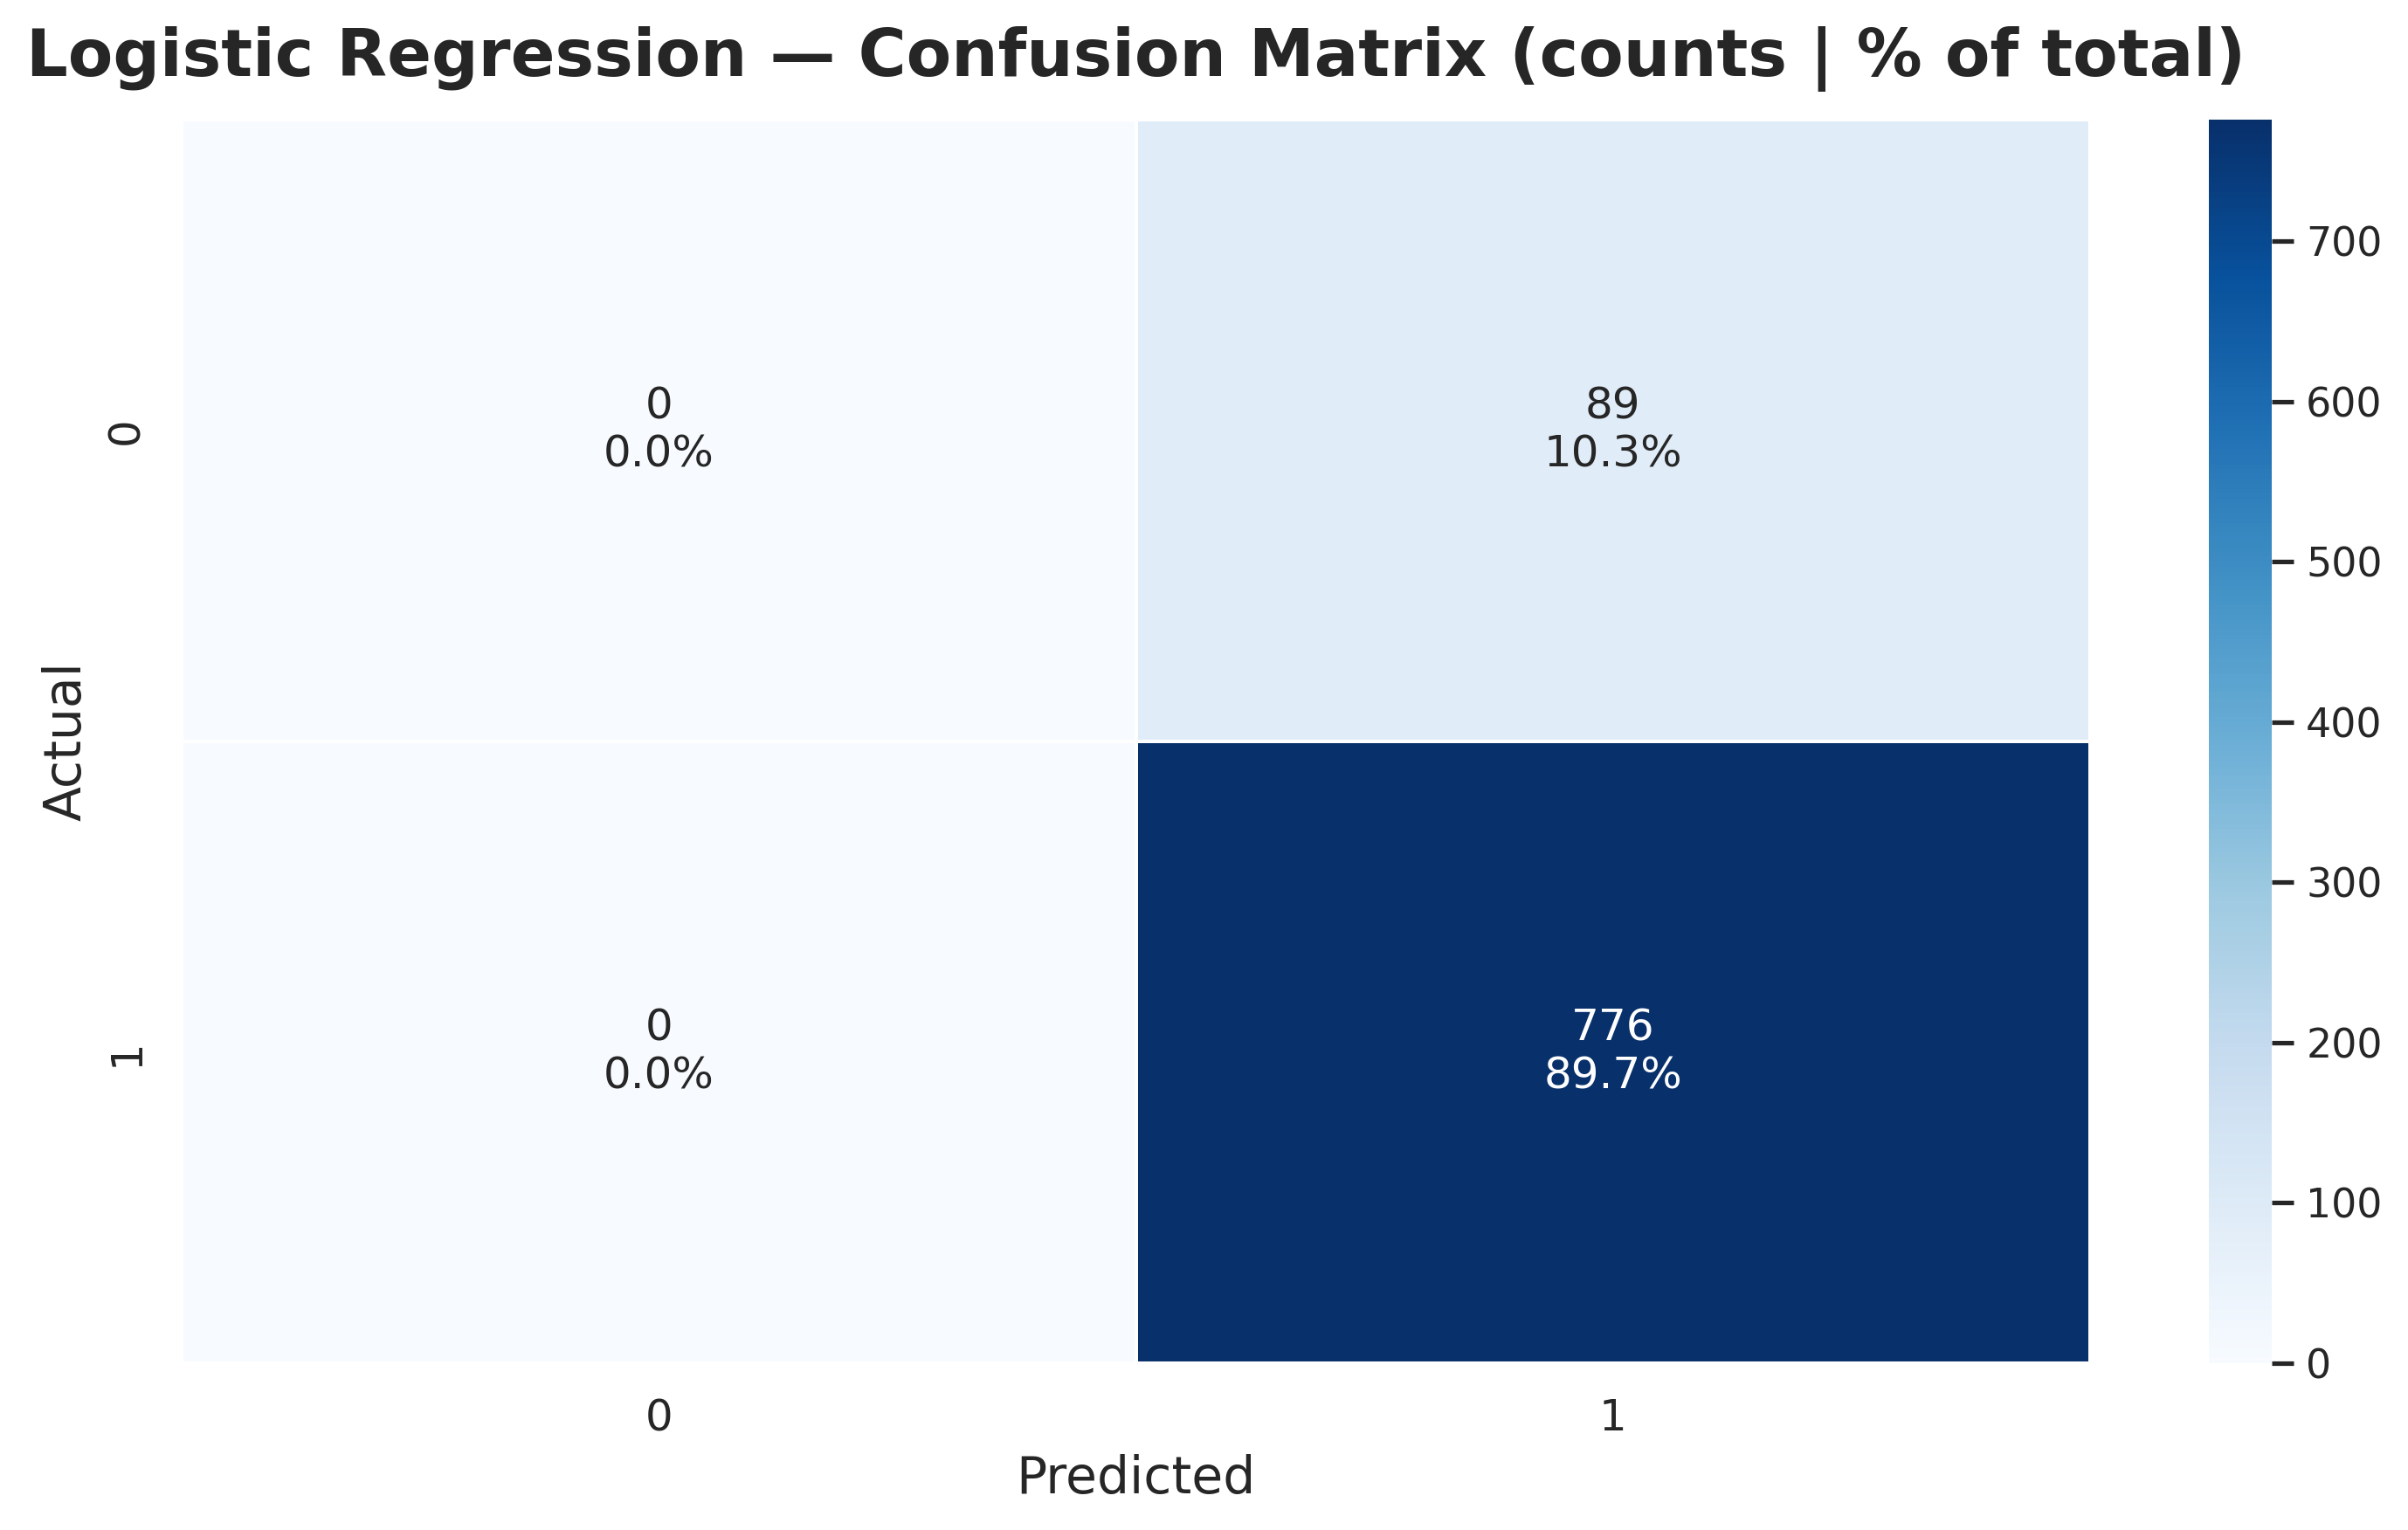

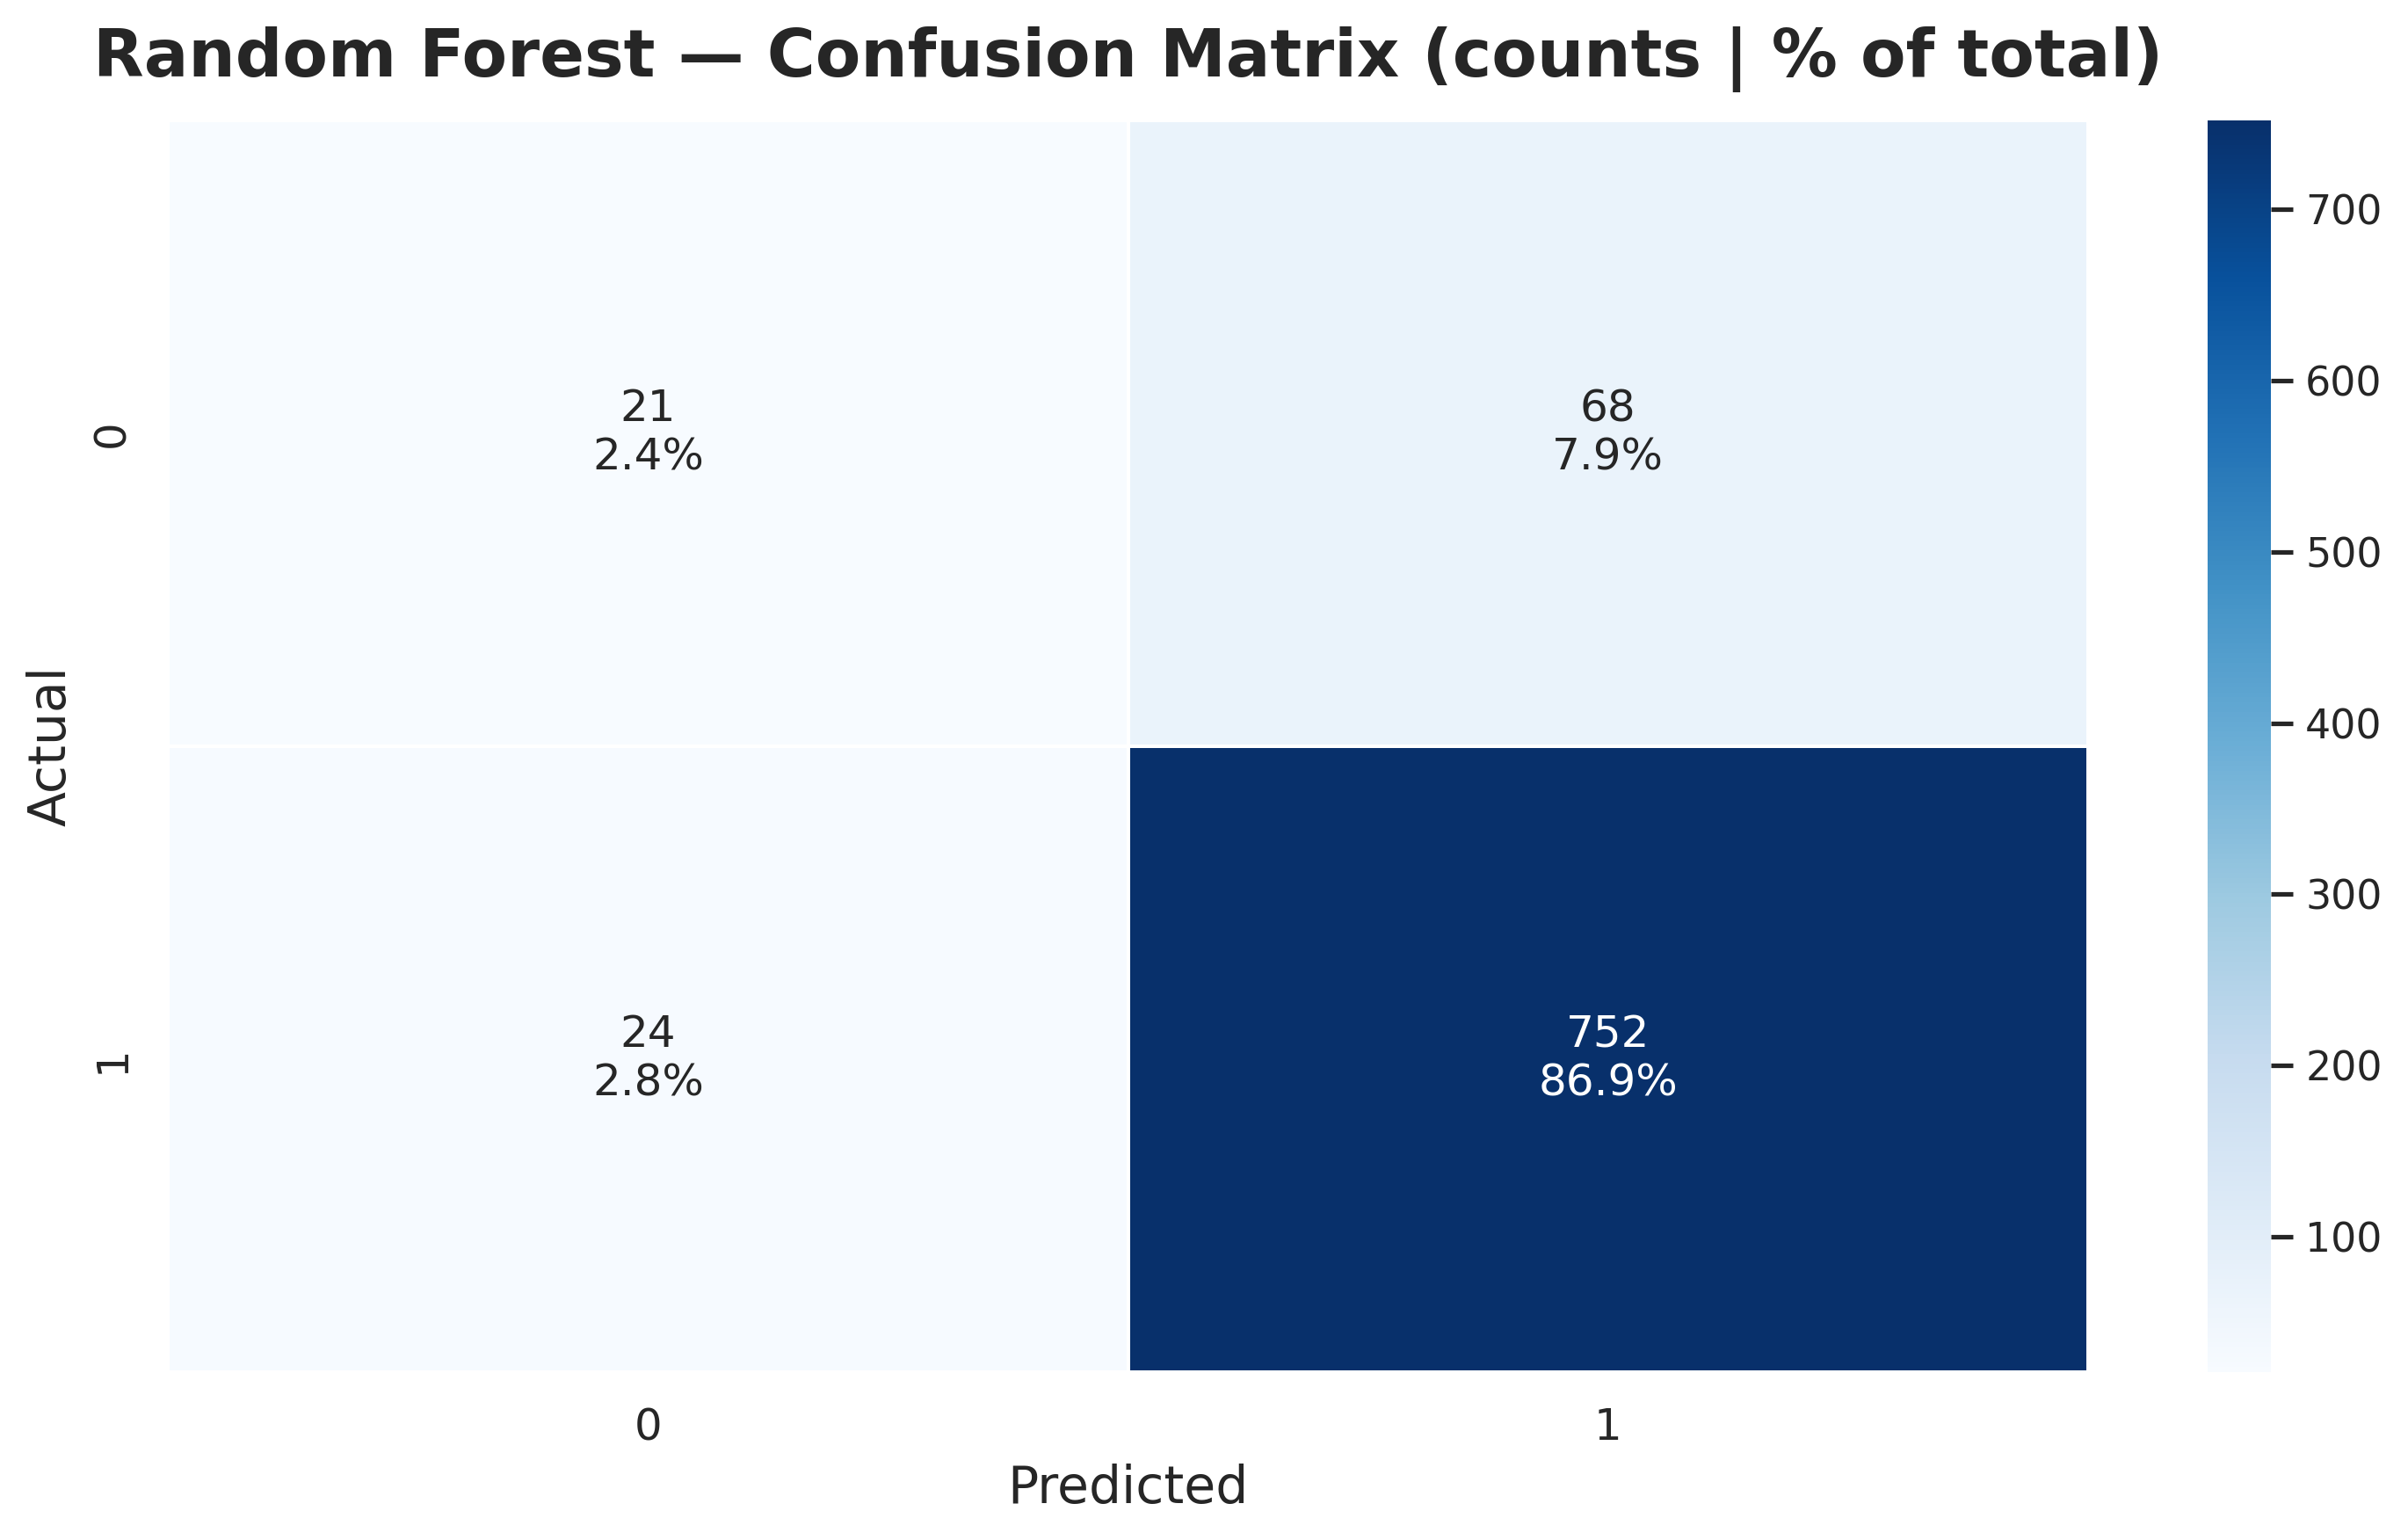

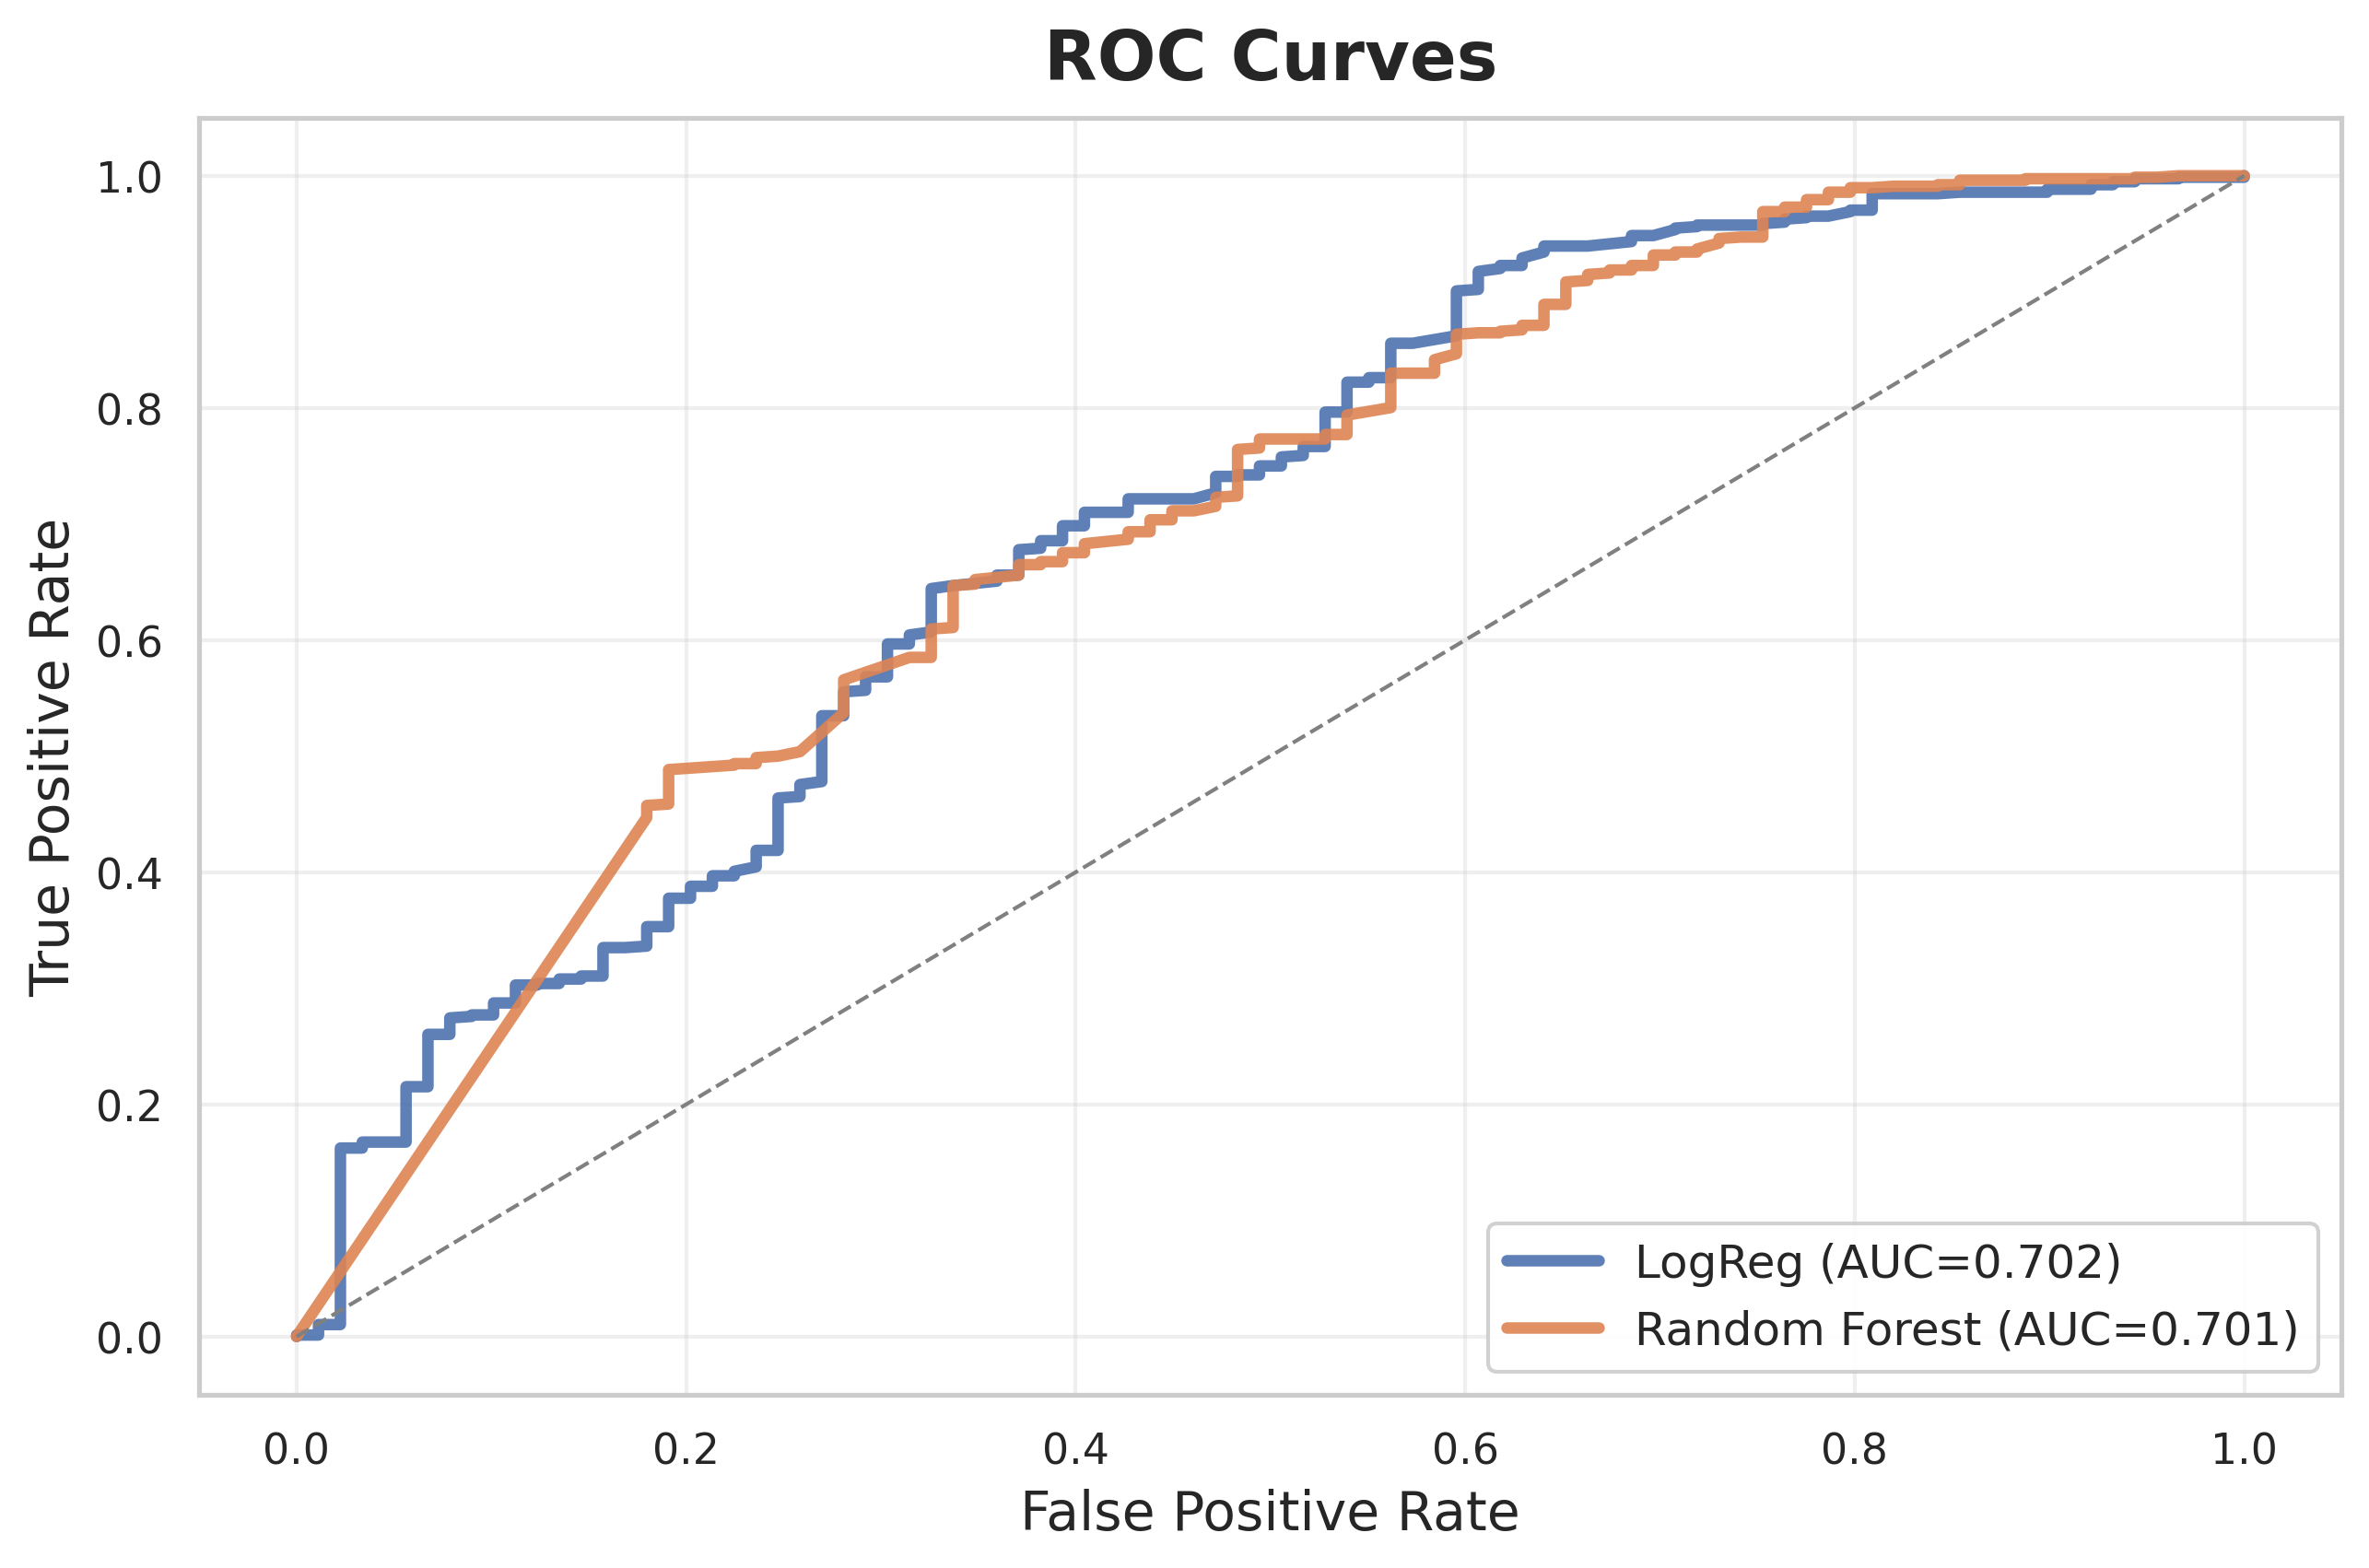

/tmp/ipython-input-3471947628.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance_pct', y='feature', data=topn, palette=colors, ax=ax)


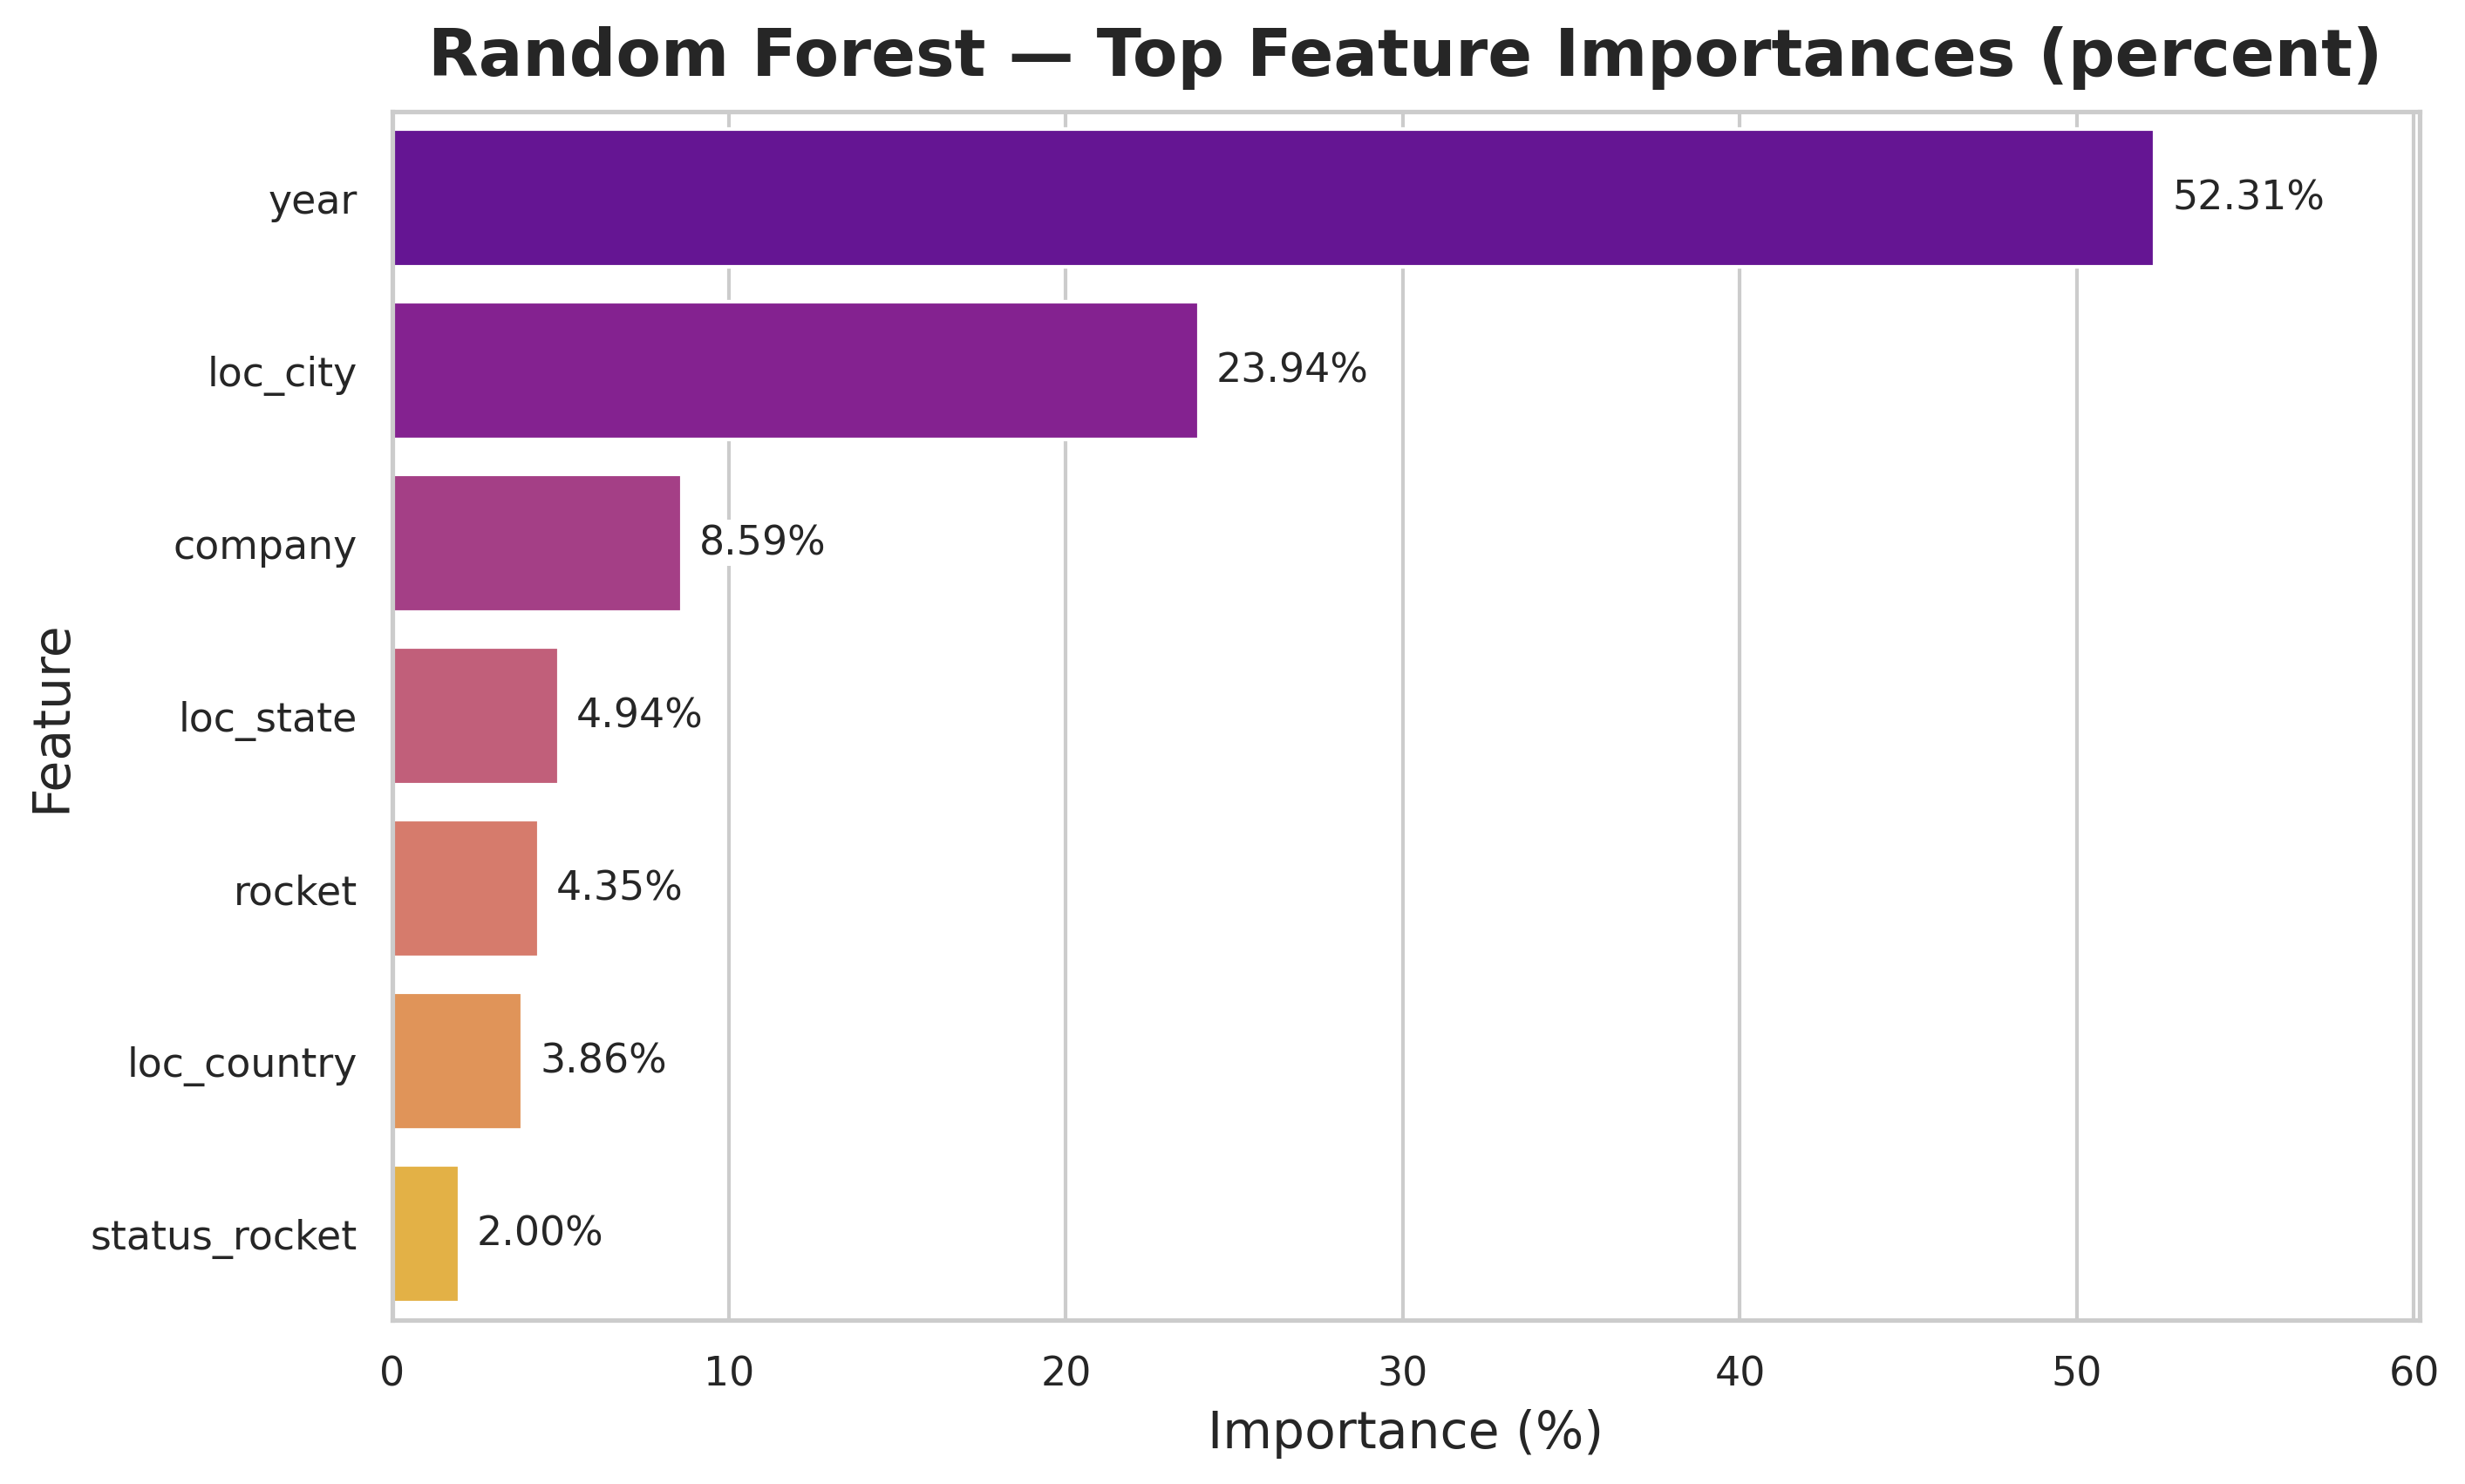

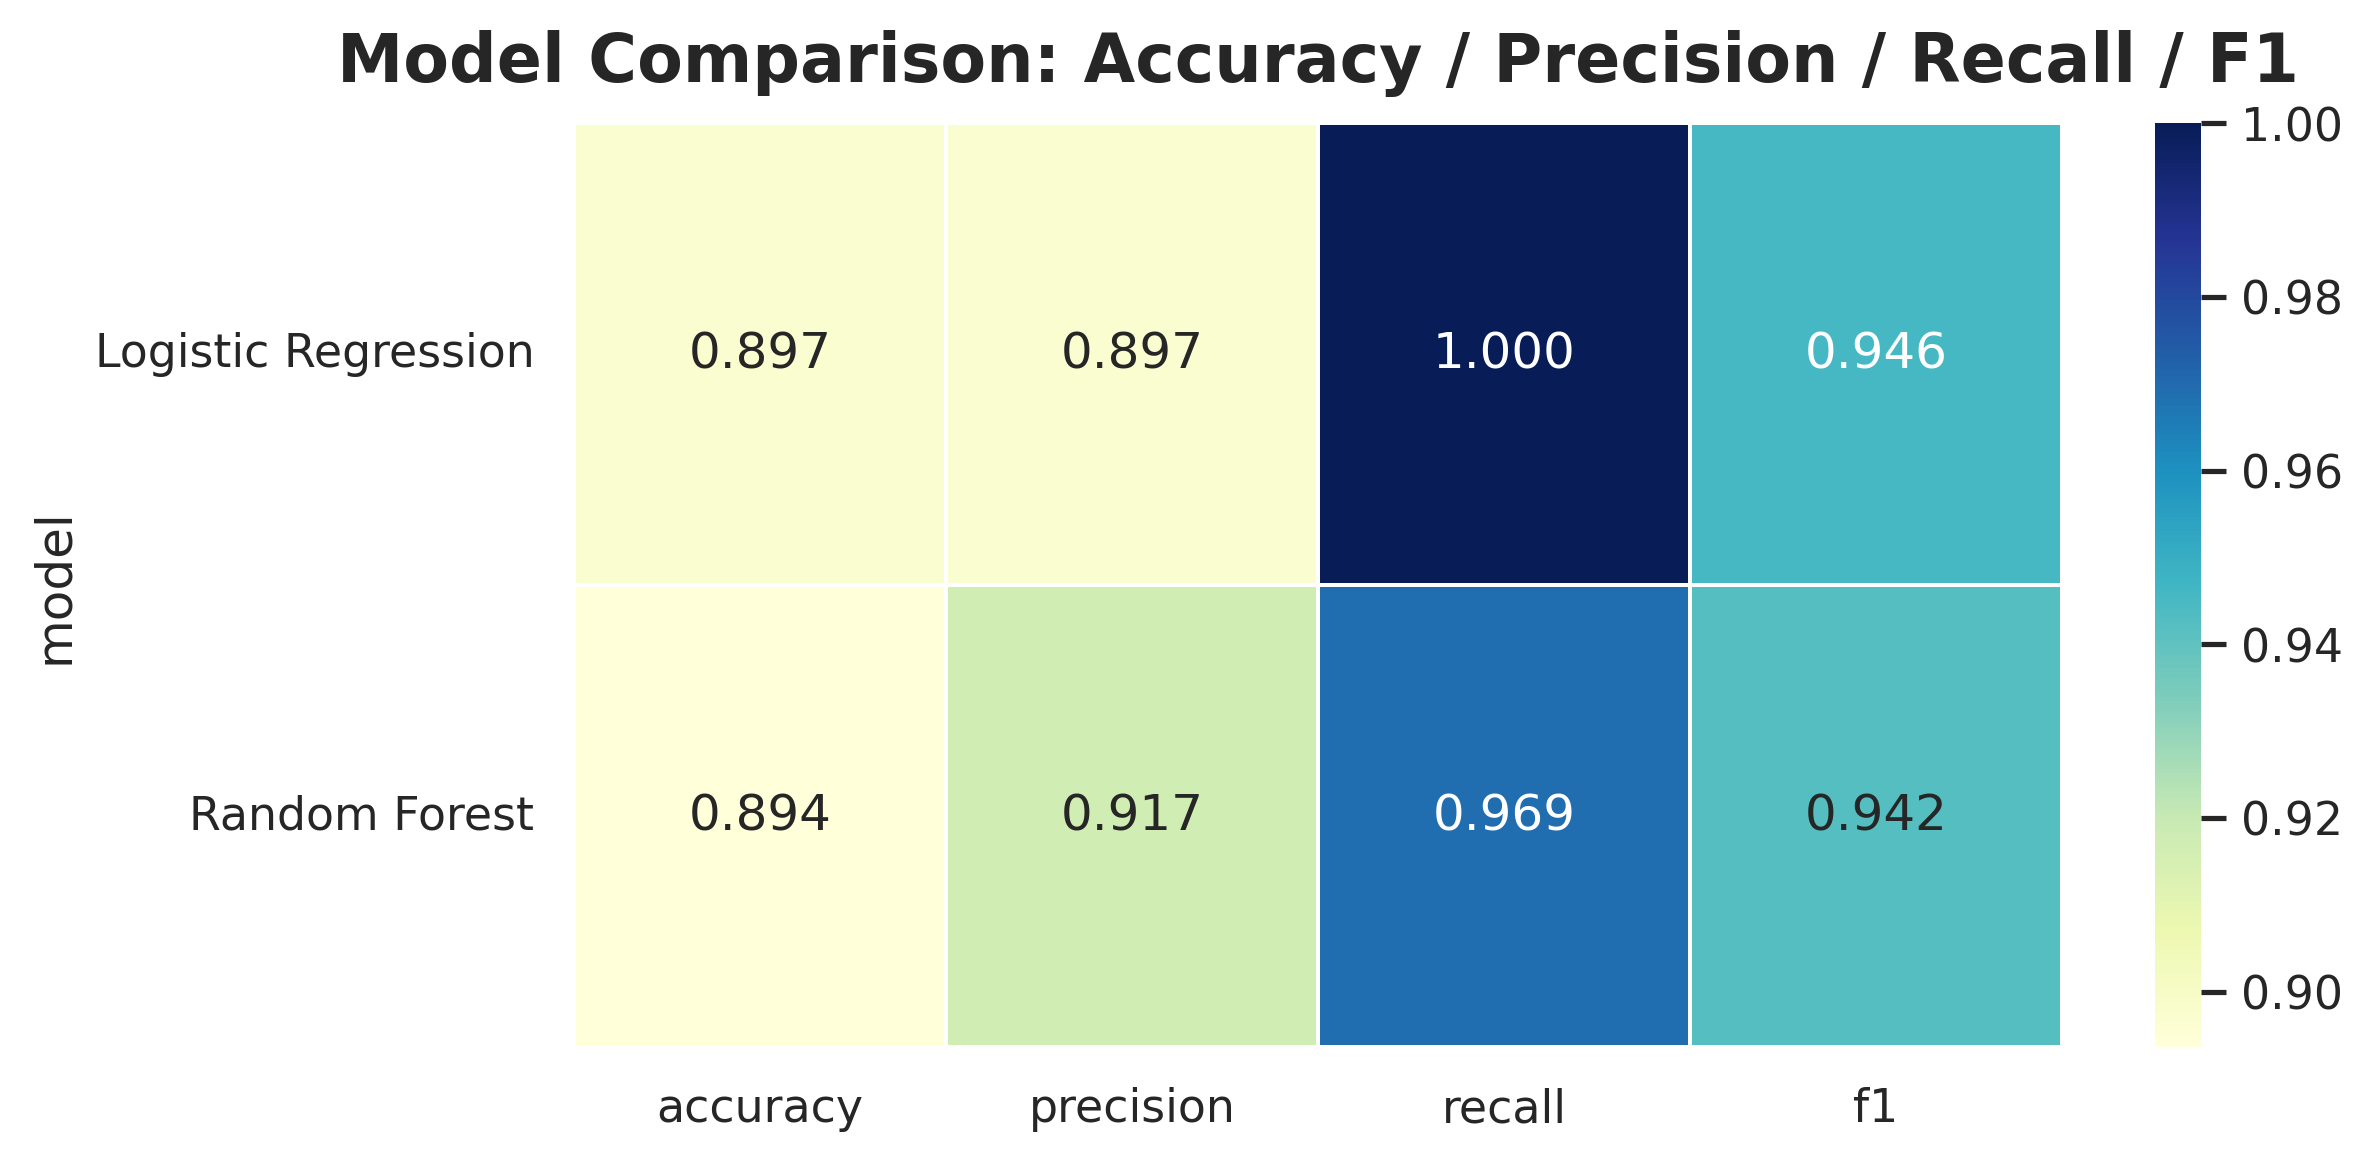

HD plots saved: hd_confusion_logreg.png, hd_confusion_rf.png, hd_roc_curves.png, hd_rf_feature_importances.png, hd_model_comparison_heatmap.png


In [71]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc


DPI = 300
FIGSIZE = (10,6)
sns.set_theme(style="whitegrid")


def plot_confusion_with_pct(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    tot = cm.sum()
    cm_pct = (cm / tot) * 100
    labels = np.array([[f"{cm[i,j]}\n{cm_pct[i,j]:.1f}%" for j in range(cm.shape[1])] for i in range(cm.shape[0])])

    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=True, ax=ax, linewidths=0.5, linecolor='white')
    ax.set_title(title, fontsize=18, pad=12)
    ax.set_xlabel("Predicted", fontsize=14)
    ax.set_ylabel("Actual", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    plt.tight_layout()
    fig.savefig(filename, bbox_inches='tight', dpi=DPI)
    plt.show()
    return cm

try:
    plot_confusion_with_pct(y_test, y_pred_log, "Logistic Regression — Confusion Matrix (counts | % of total)", "hd_confusion_logreg.png")
except Exception as e:
    print("LogReg confusion plot skipped (missing y_pred_log).", e)

try:
    plot_confusion_with_pct(y_test, y_pred_rf, "Random Forest — Confusion Matrix (counts | % of total)", "hd_confusion_rf.png")
except Exception as e:
    print("RF confusion plot skipped (missing y_pred_rf).", e)


plt.rcParams.update({'legend.frameon': True})
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

lr_proba = None
rf_proba = None
if 'pipe_logreg' in globals() and hasattr(pipe_logreg, "predict_proba"):
    lr_proba = pipe_logreg.predict_proba(X_test)[:,1]
elif 'log_reg' in globals() and hasattr(log_reg, "predict_proba"):
    lr_proba = log_reg.predict_proba(X_test)[:,1]

if 'pipe_rf' in globals() and hasattr(pipe_rf, "predict_proba"):
    rf_proba = pipe_rf.predict_proba(X_test)[:,1]
elif 'rf_model' in globals() and hasattr(rf_model, "predict_proba"):
    rf_proba = rf_model.predict_proba(X_test)[:,1]

curves_plotted = 0
if lr_proba is not None:
    fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
    lr_auc = auc(fpr_lr, tpr_lr)
    ax.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={lr_auc:.3f})', linewidth=3, alpha=0.9)
    curves_plotted += 1
if rf_proba is not None:
    fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
    rf_auc = auc(fpr_rf, tpr_rf)
    ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_auc:.3f})', linewidth=3, alpha=0.9)
    curves_plotted += 1

if curves_plotted:
    ax.plot([0,1],[0,1], linestyle='--', color='grey', linewidth=1)
    ax.set_xlabel("False Positive Rate", fontsize=14)
    ax.set_ylabel("True Positive Rate", fontsize=14)
    ax.set_title("ROC Curves", fontsize=18, pad=10)
    ax.legend(fontsize=12, loc='lower right', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    fig.savefig("hd_roc_curves.png", bbox_inches='tight', dpi=DPI)
    plt.show()
else:
    print("ROC curves skipped — predict_proba unavailable for models.")


if 'imp_df' in globals() and not imp_df.empty:

    imp = imp_df.copy()
    imp['importance_pct'] = 100 * imp['importance'] / imp['importance'].sum()
    topn = imp.head(12).copy()

    cmap = plt.get_cmap("plasma")
    colors = [cmap(x) for x in np.linspace(0.2, 0.85, len(topn))]
    fig, ax = plt.subplots(figsize=(10,6), dpi=DPI)
    sns.barplot(x='importance_pct', y='feature', data=topn, palette=colors, ax=ax)
    ax.set_xlabel("Importance (%)", fontsize=14)
    ax.set_ylabel("Feature", fontsize=14)
    ax.set_title("Random Forest — Top Feature Importances (percent)", fontsize=18, pad=10)

    for p in ax.patches:
        width = p.get_width()
        ax.text(width + topn['importance_pct'].max()*0.01, p.get_y() + p.get_height()/2,
                f"{width:.2f}%", va='center', fontsize=11, bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
    plt.xlim(0, topn['importance_pct'].max()*1.15)
    fig.savefig("hd_rf_feature_importances.png", bbox_inches='tight', dpi=DPI)
    plt.show()
else:
    print("imp_df not found — run the modeling block to create feature importances.")


if 'compare_df' in globals() and not compare_df.empty:
    cm_plot = compare_df.copy()

    fig, ax = plt.subplots(figsize=(8,4), dpi=DPI)
    sns.heatmap(cm_plot, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True, ax=ax, linewidths=0.5, linecolor='white')
    ax.set_title("Model Comparison: Accuracy / Precision / Recall / F1", fontsize=16, pad=10)
    plt.yticks(rotation=0)
    fig.savefig("hd_model_comparison_heatmap.png", bbox_inches='tight', dpi=DPI)
    plt.show()
else:
    print("compare_df not found — run the comparison creation step.")


print("HD plots saved: hd_confusion_logreg.png, hd_confusion_rf.png, hd_roc_curves.png, hd_rf_feature_importances.png, hd_model_comparison_heatmap.png")